In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

AUTOTUNE = tf.data.AUTOTUNE

RES_HEIGHT = 24
RES_WIDTH = 32
NUM_CLASS = 1

2024-04-17 15:56:21.438871: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 15:56:21.473802: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 15:56:21.473833: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 15:56:21.473852: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-17 15:56:21.481099: I tensorflow/core/platform/cpu_feature_g

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2024-04-17 15:56:23.668646: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 22198 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6
2024-04-17 15:56:23.669569: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:1 with 22198 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1f:00.0, compute capability: 8.6
2024-04-17 15:56:23.670321: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:2 with 22198 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:20:00.0, compute capability: 8.6
2024-04-17 15:56:23.670988: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:3 with 22198 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6
2024-04-17 15:56:23.671691: I tensorflow/core/common_runtime/gpu/gpu_dev

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12948753269220089167
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 23277207552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16342766857333962459
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 23277207552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8742778391930942345
 physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1f:00.0, compute capability: 8.6"
 xla_global_id: 2144165316,
 name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 23277207552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7401452042078101906
 physical_device_desc: "device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:20:00.0, compute capability: 8.6"
 xla_global

In [3]:
import numpy as np

datasets = np.load('dataset/ObjectDetection.npz', allow_pickle=True)
images, numbers, bboxes = datasets['images'], datasets['numbers'], datasets['bboxes']

max_label_length = 4
labels = []
for num in numbers:
    cls = [1] * num if num != 0 else [0]
    cls += [0] * (max_label_length - len(cls))
    labels.append(cls)

# labels = np.array(labels)

# non_zero_indices = np.where(numbers != 0)[0]
non_zero_indices = np.where(numbers > 0)[0]

# numbers가 0이 아닌 항목만 유지
images_filtered = images[non_zero_indices]
bboxes_filtered = bboxes[non_zero_indices]
labels_filtered = np.array(labels)[non_zero_indices]

print(images.shape, numbers.shape, bboxes.shape, len(labels))

print(images.max(), images.min())

dataset = {
    'images' : images_filtered,
    'bboxes' : bboxes_filtered,
    'class' : labels_filtered
}

print(dataset['images'].shape)
print(dataset['bboxes'].shape)
print(len(dataset['class']))
print(dataset['class'])


(17820, 24, 32, 1) (17820,) (17820, 4, 4) 17820
255 0
(16824, 24, 32, 1)
(16824, 4, 4)
16824
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [1 1 1 0]
 [1 1 1 0]
 [1 1 1 0]]


(24, 32, 1)
24
32
bbox:  tf.Tensor(
[[11  0 20  4]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]], shape=(4, 4), dtype=int64)


2024-04-17 15:56:23.777479: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22198 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6
2024-04-17 15:56:23.777730: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22198 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1f:00.0, compute capability: 8.6
2024-04-17 15:56:23.777957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22198 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:20:00.0, compute capability: 8.6
2024-04-17 15:56:23.778185: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22198 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

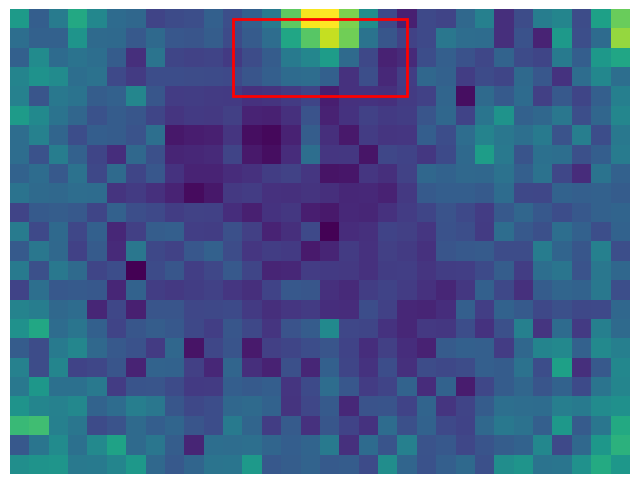

[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [1 1 1 0]
 [1 1 1 0]
 [1 1 1 0]]


In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
images = dataset['images']
bboxes = dataset['bboxes']
cls = dataset['class']

boxes = bboxes
plt.figure(figsize = (8, 8))
plt.axis('off')
image = images
print(image[0].shape)
print(image[0].shape[0])
print(image[0].shape[1])
plt.imshow(image[0])
ax = plt.gca()
boxes = boxes[0]
boxes = tf.stack([
	(boxes[:, 0] ), 
	(boxes[:, 1] ),
	(boxes[:, 2] ),
	(boxes[:, 3] )], axis = -1
)
print("bbox: ", boxes)
# 각 바운딩 박스에 대해 반복하여 그리기
for box in boxes:
    xmin, ymin, xmax, ymax = box 
    w, h = xmax - xmin, ymax - ymin
    patch = plt.Rectangle(
        [xmin, ymin], w, h, fill=False, edgecolor=[1, 0, 0], linewidth=2
    )
    ax.add_patch(patch)
plt.show()
print(cls)

In [5]:
import os
import random
import tensorflow as tf

IMG_SIZE_WIDTH = images.shape[2]
IMG_SIZE_HEIGHT = images.shape[1]
N_DATA = images.shape[0]
N_VAL = int(images.shape[0] * 0.1)
N_TRAIN = int(images.shape[0] - N_VAL)

cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'test/tfrecord/')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'od_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'od_val.tfr')

print("IMG_SIZE_WIDTH:  ", IMG_SIZE_WIDTH)
print("IMG_SIZE_HEIGHT: ", IMG_SIZE_HEIGHT)
print("N_DATA:          ", N_DATA)
print("N_TRAIN:         ", N_TRAIN)
print("N_VAL:           ", N_VAL)

shuffle_list = list(range(N_DATA))
random.shuffle(shuffle_list)

train_idx_list = shuffle_list[:N_TRAIN]
val_idx_list = shuffle_list[N_TRAIN:]

tfr_train_dir = os.path.join(tfr_dir, 'od_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'od_val.tfr')

writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

IMG_SIZE_WIDTH:   32
IMG_SIZE_HEIGHT:  24
N_DATA:           16824
N_TRAIN:          15142
N_VAL:            1682


In [6]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

def _float_feature(value):
    return tf.train.Feature(float_list = tf.train.FloatList(value = value))

def _int64_feature(value):
    return tf.train.Feature(int32_list = tf.train.Int64List(value = [value]))


def _bytes_feature_list(value_list):
    """value_list가 리스트일 때, 이를 serialize하여 bytes list로 변환하는 함수."""
    value_list = [tf.io.serialize_tensor(tf.constant(v)).numpy() for v in value_list]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value_list))


In [7]:
dataset['images'] = dataset['images']
dataset['bboxes'] = dataset['bboxes']
dataset['class'] = np.array(dataset['class'])
images = dataset['images']
bboxes = dataset['bboxes']
cls = dataset['class']
print(images.shape)
print(bboxes.shape)
print(cls.shape)


(16824, 24, 32, 1)
(16824, 4, 4)
(16824, 4)


In [8]:
for idx in train_idx_list:
    bbox = bboxes[idx]
    xmin, ymin, xmax, ymax = bbox[:, 0] / RES_WIDTH, bbox[:, 1] / RES_HEIGHT, bbox[:, 2] / RES_WIDTH, bbox[:, 3] / RES_HEIGHT
    bbox = np.stack([xmin, ymin, xmax, ymax], axis=-1).flatten()

    image = images[idx]
    bimage = image.tobytes()
    class_id = cls[idx]
    
    serialized_cls = tf.io.serialize_tensor(tf.constant(class_id)).numpy()

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'bbox': _float_feature(bbox),
        'label': _bytes_feature(serialized_cls),
        # 'number': _int64_feature(number)
    }))
    
    writer_train.write(example.SerializeToString())
writer_train.close()


In [9]:
for idx in val_idx_list:
    bbox = bboxes[idx]
    xmin, ymin, xmax, ymax = bbox[:, 0] / RES_WIDTH, bbox[:, 1] / RES_HEIGHT, bbox[:, 2] / RES_WIDTH, bbox[:, 3] / RES_HEIGHT
    
    bbox = np.stack([xmin, ymin, xmax, ymax], axis=-1).flatten()
    image = images[idx]
    bimage = image.tobytes()
    class_id = cls[idx]

    serialized_cls = tf.io.serialize_tensor(tf.constant(class_id)).numpy()

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'bbox': _float_feature(bbox),
        'label': _bytes_feature(serialized_cls),
    }))
    
    writer_val.write(example.SerializeToString())
writer_val.close()


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

N_BATCH = 1

def _parse_function(tfrecord_serialized):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'bbox': tf.io.VarLenFeature(tf.float32),  
        'label': tf.io.FixedLenFeature([], tf.string),
    }

    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)

    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [RES_HEIGHT, RES_WIDTH, 1])
    image = tf.cast(image, tf.float32) 

    bbox = tf.sparse.to_dense(parsed_features['bbox']) 
    bbox = tf.cast(bbox, tf.float32)
    bbox = tf.reshape(bbox, [-1, 4])

    serialized_cls = parsed_features['label']
    label = tf.io.parse_tensor(serialized_cls, out_type=tf.int64)
    
    return image, bbox, label



train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(AUTOTUNE).batch(N_BATCH, drop_remainder=True)

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

N_BATCH = 1

def _parse_function(tfrecord_serialized):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'bbox': tf.io.VarLenFeature(tf.float32),  
        'label': tf.io.FixedLenFeature([], tf.string),
    }

    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)

    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [RES_HEIGHT, RES_WIDTH, 1])
    image = tf.cast(image, tf.float32) 

    bbox = tf.sparse.to_dense(parsed_features['bbox']) 
    bbox = tf.cast(bbox, tf.float32)
    bbox = tf.reshape(bbox, [-1, 4])

    serialized_cls = parsed_features['label']
    label = tf.io.parse_tensor(serialized_cls, out_type=tf.int64)
    
    return image, bbox, label



val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=N_TRAIN).prefetch(AUTOTUNE).batch(N_BATCH, drop_remainder=True)

In [12]:
for img, bbox, label in val_dataset.take(1):
    print(img.shape)
    print(bbox)
    print(label)

(1, 24, 32, 1)
tf.Tensor(
[[[0.25       0.75       0.53125    1.        ]
  [0.03125    0.         0.375      0.33333334]
  [0.         0.         0.         0.        ]
  [0.         0.         0.         0.        ]]], shape=(1, 4, 4), dtype=float32)
tf.Tensor([[1 1 0 0]], shape=(1, 4), dtype=int64)


In [13]:
val = 0
for _, _, _ in val_dataset:
    val += 1
print(val)


train = 0
for _, _, _ in train_dataset:
    train += 1
print(train)


1682
15142


(24, 32, 1)
tf.Tensor([1 1 0 0], shape=(4,), dtype=int64)
tf.Tensor(
[[0.78125    0.04166667 0.9375     0.29166666]
 [0.59375    0.125      0.8125     0.45833334]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]], shape=(4, 4), dtype=float32)


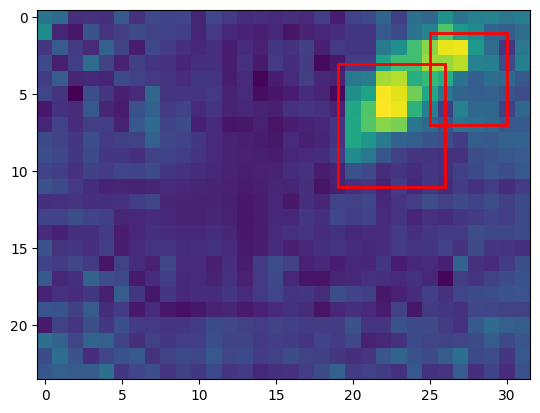

In [14]:
import matplotlib.pyplot as plt

idx = 0
for image, bbox, label in val_dataset.take(1):
    image = image[idx]
    bbox = bbox[idx]
    label = label[idx]
    image = image.numpy()
    plt.imshow(image)
    ax = plt.gca()  
    print(image.shape)
    print(label)
    print(bbox)
    boxes = tf.stack(
    	[
    	 bbox[:,0] * RES_WIDTH,
    	 bbox[:,1] * RES_HEIGHT,
    	 bbox[:,2] * RES_WIDTH,
    	 bbox[:,3] * RES_HEIGHT
    	], axis = -1
    )
    for box in boxes:
        xmin, ymin = box[:2]
        w, h = box[2:] - box[:2]
        patch = plt.Rectangle(
            [xmin, ymin], w, h, fill=False, edgecolor=[1, 0, 0], linewidth=2
        )
        ax.add_patch(patch)
    plt.show()

In [15]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1
    )

def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1
    )

In [16]:
def preprocess_data(image, gt_boxes, cls_ids):
    bbox = convert_to_xywh(gt_boxes)
    return image, bbox, cls_ids

In [17]:
for image, bbox, label in val_dataset.take(1):
    print(image.shape)
    print(bbox.shape)
    print(label.shape)

(1, 24, 32, 1)
(1, 4, 4)
(1, 4)


(24, 32, 1)
tf.Tensor(
[[0.71875    0.7291666  0.25       0.2916667 ]
 [0.453125   0.7291667  0.21875    0.375     ]
 [0.15625    0.7708334  0.1875     0.20833331]
 [0.         0.         0.         0.        ]], shape=(4, 4), dtype=float32)
tf.Tensor([1 1 1 0], shape=(4,), dtype=int64)
tf.Tensor(199.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
width:  32
height:  24
bbox:  tf.Tensor(
[[0.59375    0.58333325 0.25       0.2916667 ]
 [0.34375    0.5416667  0.21875    0.375     ]
 [0.0625     0.66666675 0.1875     0.20833331]
 [0.         0.         0.         0.        ]], shape=(4, 4), dtype=float32)
tf.Tensor([0.59375    0.58333325 0.25       0.2916667 ], shape=(4,), dtype=float32)
tf.Tensor([0.34375   0.5416667 0.21875   0.375    ], shape=(4,), dtype=float32)
tf.Tensor([0.0625     0.66666675 0.1875     0.20833331], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)


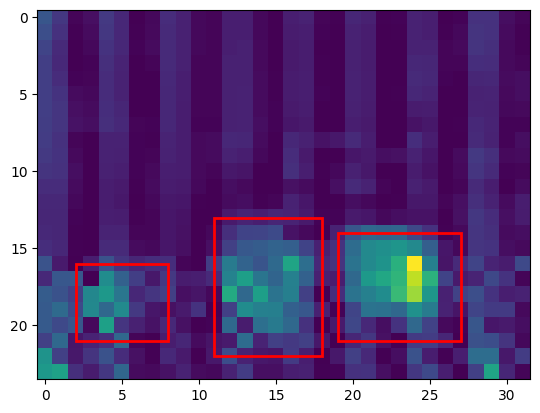

tf.Tensor([1 1 1 0], shape=(4,), dtype=int64)


In [18]:
idx = 0
for image, bbox, label in val_dataset.take(1):
    image, bbox, label = preprocess_data(image, bbox, label)
    img = image[idx]
    box = bbox[idx]
    label = label[idx]
    print(img.shape)
    print(box)
    print(label)
    print(tf.reduce_max(image), tf.reduce_min(image))
    # 이미지 시각화
    plt.imshow(img)
    ax = plt.gca()
    width = img.shape[1]
    height = img.shape[0]
    print("width: ", width)
    print("height: ", height)
    boxes = tf.stack(
        [
            (box[:, 0] - 0.5 * box[:, 2]),  # xmin = x_center - width/2
            (box[:, 1] - 0.5 * box[:, 3]),  # ymin = y_center - height/2
            box[:, 2],
            box[:, 3],
            
        ], axis=-1
    )
    print("bbox: ", boxes)
    # 각 바운딩 박스에 대해 반복하여 그리기
    for box in boxes:
        xmin, ymin, w, h = box
        print(box)
        patch = plt.Rectangle(
            [xmin * RES_WIDTH, ymin * RES_HEIGHT], w * RES_WIDTH, h * RES_HEIGHT, fill=False, edgecolor=[1, 0, 0], linewidth=2
        )
        ax.add_patch(patch)
    plt.show()
    print(label)
 

(24, 32, 1)
tf.Tensor(
[[0.859375   0.6666667  0.28125    0.41666666]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]], shape=(4, 4), dtype=float32)
tf.Tensor([1 0 0 0], shape=(4,), dtype=int64)
tf.Tensor(220.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
width:  32
height:  24
bbox:  tf.Tensor(
[[0.71875    0.45833337 0.28125    0.41666666]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]], shape=(4, 4), dtype=float32)
tf.Tensor([0.71875    0.45833337 0.28125    0.41666666], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)


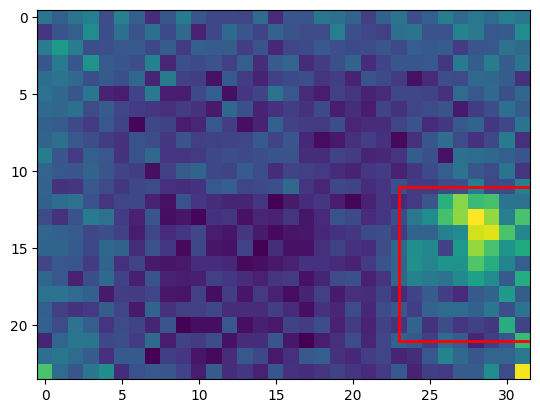

tf.Tensor([1 0 0 0], shape=(4,), dtype=int64)


In [19]:
idx = 0
for image, bbox, label in train_dataset.take(1):
    image, bbox, label = preprocess_data(image, bbox, label)
    img = image[idx]
    box = bbox[idx]
    label = label[idx]
    print(img.shape)
    print(box)
    print(label)
    print(tf.reduce_max(image), tf.reduce_min(image))
    # 이미지 시각화
    plt.imshow(img)
    ax = plt.gca()
    width = img.shape[1]
    height = img.shape[0]
    print("width: ", width)
    print("height: ", height)
    boxes = tf.stack(
        [
            (box[:, 0] - 0.5 * box[:, 2]),  # xmin = x_center - width/2
            (box[:, 1] - 0.5 * box[:, 3]),  # ymin = y_center - height/2
            box[:, 2],
            box[:, 3],
            
        ], axis=-1
    )
    print("bbox: ", boxes)
    # 각 바운딩 박스에 대해 반복하여 그리기
    for box in boxes:
        xmin, ymin, w, h = box
        print(box)
        patch = plt.Rectangle(
            [xmin * RES_WIDTH, ymin * RES_HEIGHT], w * RES_WIDTH, h * RES_HEIGHT, fill=False, edgecolor=[1, 0, 0], linewidth=2
        )
        ax.add_patch(patch)
    plt.show()
    print(label)
 

In [20]:
import numpy as np
from sklearn.cluster import KMeans

def compute_anchor_boxes(bboxes, img_width, img_height):
    all_bboxes = []
    for image_bboxes in bboxes:
        # 정규화된 좌표를 픽셀 단위 좌표로 변환
        pixel_bboxes = np.copy(image_bboxes)
        pixel_bboxes[:, 0] *= img_width
        pixel_bboxes[:, 1] *= img_height
        pixel_bboxes[:, 2] *= img_width
        pixel_bboxes[:, 3] *= img_height
        all_bboxes.extend(pixel_bboxes)
    
    all_bboxes = np.array(all_bboxes)
    
    # 높이가 0인 바운딩 박스 제거
    valid_bboxes = all_bboxes[np.logical_and(all_bboxes[:, 2] > all_bboxes[:, 0], all_bboxes[:, 3] > all_bboxes[:, 1])]
    
    box_sizes = valid_bboxes[:, 2:] - valid_bboxes[:, :2]
    box_ratios = box_sizes[:, 0] / box_sizes[:, 1]
    
    data = np.column_stack((box_sizes[:, 0], box_sizes[:, 1], box_ratios))
    
    kmeans = KMeans(n_clusters=4, random_state=0).fit(data)
    
    anchor_sizes = kmeans.cluster_centers_[:, :2]
    anchor_ratios = kmeans.cluster_centers_[:, 2]
    
    return anchor_sizes, anchor_ratios

bboxes = []
for image, image_bboxes, label in train_dataset:
    bboxes.append(image_bboxes.numpy())

# 이미지 너비와 높이 설정
img_width = 32
img_height = 24

anchor_sizes, anchor_ratios = compute_anchor_boxes(bboxes, img_width, img_height)
print("anchor_sizes (pixels): ", anchor_sizes)
print("anchor_ratios: ", anchor_ratios)

anchor_sizes (pixels):  [[ 5.6837234  6.965325 ]
 [ 8.902596  13.506494 ]
 [ 9.537355   8.85249  ]
 [ 6.2529287 10.704428 ]]
anchor_ratios:  [0.83647734 0.6655831  1.1121049  0.5899664 ]


In [21]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.65, 1.0]        
        self.scales = [2** x for x in [1/3, 2/3]]
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(1, 2)]
        self._areas = [x ** 2 for x in [5.5, 6.2, 6.8]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1),
                    [1, 1, 2]
                )
                dims = tf.cast(dims, tf.float32)  # 데이터 타입을 float32로 변환
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all
    
    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype = tf.float32) + 0.5
        ry = tf.range(feature_height, dtype = tf.float32) + 0.5

        centers = tf.stack(tf.meshgrid(rx, ry), axis = -1) * self._strides[level - 1] # stride시작점에 따라 바꿔야함 
        centers = tf.expand_dims(centers, axis = -2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])

        dims = tf.tile(
            self._anchor_dims[level - 1], [feature_height, feature_width, 1, 1] 
        )

        anchors = tf.concat([centers, dims], axis=-1) 

        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i), # 올림
                tf.math.ceil(image_width / 2 ** i),
                i
            )
            for i in range(1, 2)
        ]

        return tf.concat(anchors, axis=0)

Anchor 음수 값: False


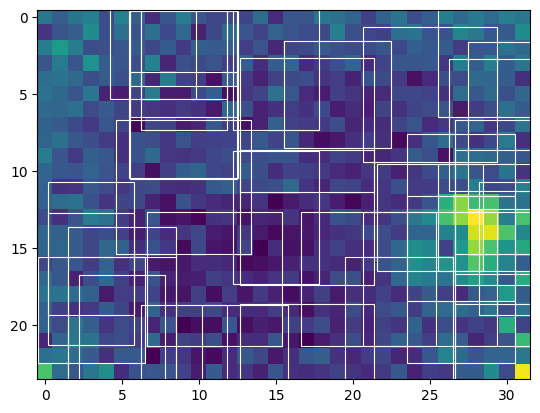

In [22]:
anchors = AnchorBox()
anchor = anchors.get_anchors(24, 32)

# 앵커 박스 정규화
xmin = anchor[:, 0] / RES_WIDTH
ymin = anchor[:, 1] / RES_HEIGHT
xmax = anchor[:, 2] / RES_WIDTH
ymax = anchor[:, 3] / RES_HEIGHT

# 정규화된 좌표를 스택으로 결합
normalized_anchor = tf.stack([xmin, ymin, xmax, ymax], axis=-1)

has_negative_values = tf.reduce_any(tf.less(anchor, 0))
print("Anchor 음수 값:", has_negative_values.numpy())

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bounding_boxes(data, num_samples):
    fig, ax = plt.subplots()

    plt.imshow(img)
    data_np = data.numpy()

    if len(data) > num_samples:
        sampled_indices = np.random.choice(len(data), num_samples, replace=False)
        sample_data = data_np[sampled_indices]
    else : 
        sample_data = data_np
    for center_x, center_y, width, height in sample_data:
        top_left_x = center_x - width / 2
        top_left_y = center_y - height / 2

        rect = patches.Rectangle((top_left_x * RES_WIDTH, top_left_y * RES_HEIGHT), width * RES_WIDTH, height * RES_HEIGHT, linewidth=0.8, edgecolor='white', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

draw_bounding_boxes(normalized_anchor, 40)


In [23]:
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])  
    
    intersection = tf.maximum(rd - lu, 0.0)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = (boxes1_corners[:, 2] - boxes1_corners[:, 0]) * (boxes1_corners[:, 3] - boxes1_corners[:, 1])
    boxes2_area = (boxes2_corners[:, 2] - boxes2_corners[:, 0]) * (boxes2_corners[:, 3] - boxes2_corners[:, 1])
    union_area = tf.maximum(boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8)

    return intersection_area / union_area

In [24]:
# class LabelEncoder:
#     def __init__(self):
#         self._anchor_box = AnchorBox()
#         self._box_variance = tf.convert_to_tensor(
#             [0.1, 0.1, 0.2, 0.2], dtype=tf.float32)
    
#     def _match_anchor_boxes(self, anchor_boxes, gt_boxes, match_iou = 0.5, ignore_iou = 0.4):
#         iou_matrix = compute_iou(anchor_boxes, gt_boxes)
#         max_iou = tf.reduce_max(iou_matrix, axis=1)

#         matched_gt_idx = tf.argmax(iou_matrix, axis = 1)
#         positive_mask = tf.greater_equal(max_iou, match_iou)
#         negative_mask = tf.less(max_iou, ignore_iou)

#         ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
#         return (
#             matched_gt_idx,
#             tf.cast(positive_mask, dtype = tf.float32),
#             tf.cast(ignore_mask, dtype = tf.float32),
#         )
    
#     def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
#         box_target = tf.concat(
#             [
#                 (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
#                 tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:])
#             ],
#             axis = -1,
#         )
#         box_target = box_target / self._box_variance
#         return box_target
    

#     def _encode_sample(self, image_shape, gt_boxes, cls_ids):        
#         anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
#         # 앵커 박스 정규화
#         xmin = anchor_boxes[:, 0] / RES_WIDTH
#         ymin = anchor_boxes[:, 1] / RES_HEIGHT
#         xmax = anchor_boxes[:, 2] / RES_WIDTH
#         ymax = anchor_boxes[:, 3] / RES_HEIGHT

#         # 정규화된 좌표를 스택으로 결합
#         normalized_anchor = tf.stack([xmin, ymin, xmax, ymax], axis=-1)
        
#         cls_ids = tf.cast(cls_ids, dtype=tf.float32)
#         matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
#             normalized_anchor, gt_boxes
#         )

#         matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)

        
#         box_target = self._compute_box_target(normalized_anchor, matched_gt_boxes)

#         matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)

#         cls_target = tf.where(tf.cast(positive_mask, tf.bool), matched_gt_cls_ids, -1.0)
#         cls_target = tf.where(tf.cast(ignore_mask, tf.bool), -2.0, cls_target)

#         cls_target = tf.expand_dims(cls_target, axis=-1)
#         num_ones = tf.math.count_nonzero(tf.equal(cls_target, 1.0))
#         print("Number of 1.0 values in cls_target:", num_ones)
#         label = tf.concat([box_target, cls_target], axis=-1)
#         return label

#     def encode_batch(self, batch_images, gt_boxes, cls_ids):       
#         images_shape = tf.shape(batch_images)
#         batch_size = images_shape[0]

#         labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
#         for i in range(batch_size):
#             label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
#             labels = labels.write(i, label)
#         return batch_images, labels.stack()

# 테스트 하시오

In [25]:
import tensorflow as tf

class LabelEncoder:
    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32)
    
    def _match_anchor_boxes(self, anchor_boxes, gt_boxes, match_iou=0.5):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        return matched_gt_idx, max_iou
    
    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:])
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):        
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        # Normalize anchor boxes
        xmin = anchor_boxes[:, 0] / RES_WIDTH
        ymin = anchor_boxes[:, 1] / RES_HEIGHT
        xmax = anchor_boxes[:, 2] / RES_WIDTH
        ymax = anchor_boxes[:, 3] / RES_HEIGHT
        normalized_anchor = tf.stack([xmin, ymin, xmax, ymax], axis=-1)
        
        matched_gt_idx, iou_scores = self._match_anchor_boxes(normalized_anchor, gt_boxes)
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(normalized_anchor, matched_gt_boxes)
        
        # Use IoU scores as labels for classification
        cls_target = iou_scores
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]
        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        return batch_images, labels.stack()

In [26]:
autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)

In [27]:
label_encoder = LabelEncoder()

train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)

val_dataset = val_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)

In [28]:
positive_count = []
negative_count = []
ignore_count = []
for batch in train_dataset.take(3):
    images, labels = batch
    print(np.array(images).max(), np.array(images).min())
    print(labels.shape)

    # labels 텐서에서 positive, negative, ignore 값의 개수를 계산
    positive_count = tf.reduce_sum(tf.cast(tf.equal(labels[0, :, 4], 1.0), tf.int32))
    negative_count = tf.reduce_sum(tf.cast(tf.equal(labels[0, :, 4], -1.0), tf.int32))
    ignore_count = tf.reduce_sum(tf.cast(tf.equal(labels[0, :, 4], -2.0), tf.int32))
    # positive_count = tf.reduce_sum(tf.cast(tf.greater(labels[:, 4], 0.5), tf.int32))
    # negative_count = tf.reduce_sum(tf.cast(tf.less_equal(labels[:, 4], 0.5), tf.int32))
    # ignore_count = tf.reduce_sum(tf.cast(tf.logical_and(tf.greater(labels[:, 4], 0.1), tf.less_equal(labels[:, 4], 0.5)), tf.int32))

    print("Positive 개수:", positive_count.numpy())
    print("Negative 개수:", negative_count.numpy())
    print("Ignore 개수:", ignore_count.numpy())


254.0 0.0
(1, 768, 5)
Positive 개수: 0
Negative 개수: 0
Ignore 개수: 0
248.0 0.0
(1, 768, 5)
Positive 개수: 0
Negative 개수: 0
Ignore 개수: 0
242.0 0.0
(1, 768, 5)
Positive 개수: 0
Negative 개수: 0
Ignore 개수: 0


Positive 개수: 0
Negative 개수: 752
Ignore 개수: 0
Positive 0


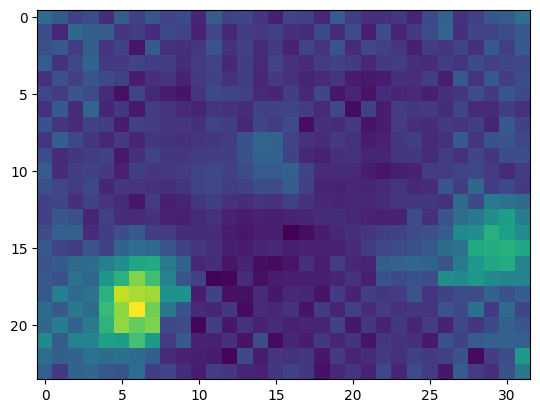

In [29]:
def decode_predictions(labels, anchors, box_variance=[0.1, 0.1, 0.2, 0.2]):
    decoded_boxes = []
    label_idx = 0
    for label in labels:
        # if label[4] == 1.0:
        #     print("label:", label)
        # elif label[4] == -1.0:
        #     print("label:", label)
        dx, dy, dw, dh = label[:4]
        anchor = anchors[label_idx]
        anchor_x, anchor_y, anchor_w, anchor_h = anchor
        cx = dx * box_variance[0] * anchor_w + anchor_x
        cy = dy * box_variance[1] * anchor_h + anchor_y
        width = np.exp(dw * box_variance[2]) * anchor_w
        height = np.exp(dh * box_variance[3]) * anchor_h
        x_min = cx - width / 2
        y_min = cy - height / 2
        decoded_box = [x_min, y_min, width, height]
        # print(np.array(decoded_box))
        if label[4] == 1.0:
            decoded_boxes.append(decoded_box)
        label_idx += 1
        # if len(np.array(decoded_boxes)) > 1: 
            # break
    print("Positive",len(np.array(decoded_boxes)))
    return decoded_boxes    
    # print(np.array(decoded_boxes))
    

# 바운딩 박스 그리기 함수
def draw_positive_bounding_boxes(image, decoded_boxes):
    plt.imshow(image)
    ax = plt.gca()
    # print(len(decoded_boxes))
    i = 0
    for box in decoded_boxes:
        i+=1
        # print(box)
        x_min, y_min, width, height = box
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    # print(i)
    plt.show()

# 앵커 박스 생성
anchor_box = AnchorBox()
anchors = anchor_box.get_anchors(24, 32)
# train_dataset에서 첫 번째 배치를 가져오고, 바운딩 박스 그리기
for batch in train_dataset.take(1):
    image = batch[0][0].numpy()
    labels = batch[1][0].numpy()  # 여기서 labels는 [오프셋x, 오프셋y, 스케일w, 스케일h, 클래스, 앵커 박스 인덱스]를 포함한다고 가정
    # print(labels)
    positive_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, 4], 1.0), tf.int32))
    negative_count = tf.reduce_sum(tf.cast(tf.less_equal(labels[:, 4], 0.5), tf.int32))
    ignore_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, 4], -2.0), tf.int32))
    # positive_count = tf.reduce_sum(tf.cast(tf.greater(labels[:, 4], 0.5), tf.int32))
    # negative_count = tf.reduce_sum(tf.cast(tf.less_equal(labels[:, 4], 0.5), tf.int32))
    # ignore_count = tf.reduce_sum(tf.cast(tf.logical_and(tf.greater(labels[:, 4], 0.1), tf.less_equal(labels[:, 4], 0.5)), tf.int32))

    print("Positive 개수:", positive_count.numpy())
    print("Negative 개수:", negative_count.numpy())
    print("Ignore 개수:", ignore_count.numpy())

    # 오프셋 디코딩 및 바운딩 박스 그리기
    decoded_boxes = decode_predictions(labels, anchors)
    draw_positive_bounding_boxes(image, decoded_boxes)

In [30]:
class DepthwiseSeparableConv(layers.Layer):
    def __init__(self, out_channels, kernel_size, stride=1, padding=0):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = layers.DepthwiseConv2D(kernel_size=kernel_size, padding='same' if padding else 'valid', depth_multiplier=1, strides=stride, kernel_initializer=tf.keras.initializers.HeNormal())
        self.pointwise = layers.Conv2D(out_channels, kernel_size=1, strides=1, kernel_initializer=tf.keras.initializers.HeNormal())

    def call(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class DepthwiseConv(layers.Layer):
    def __init__(self, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseConv, self).__init__()
        self.depthwise = DepthwiseSeparableConv(out_channels, kernel_size, stride, padding)
        self.batch_norm = layers.BatchNormalization()
        self.relu = layers.Activation('relu')

    def call(self, x):
        out = self.depthwise(x)
        out = self.batch_norm(out)
        out = self.relu(out)
        return out

In [31]:
class Conv(layers.Layer):
    def __init__(self, out_channels, kernel_size=3, stride=2, padding='SAME'):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(out_channels, kernel_size, strides=stride, padding=padding, kernel_initializer=tf.keras.initializers.HeNormal())
        self.batch_norm = layers.BatchNormalization()
        self.relu = layers.Activation('relu')

    def call(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        return self.relu(x)

In [32]:
class Bottleneck(layers.Layer):
    def __init__(self, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv_0 = Conv(out_channels, kernel_size=1, stride=stride, padding='same')
        self.conv_1 = Conv(out_channels, kernel_size=3, stride=stride, padding='same')

    def call(self, x):
        identity = x
        out = self.conv_0(x)
        out = self.conv_1(out)
        out += identity
        return out

In [33]:
class ChannelAttention(layers.Layer):
    def __init__(self, pool_types=['avg', 'max'], kernel_size=3):
        super(ChannelAttention, self).__init__()
        self.pool_types = pool_types
        self.conv = layers.Conv2D(1, kernel_size=kernel_size, strides=1, padding='same', use_bias=False, kernel_initializer=tf.keras.initializers.HeNormal())
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x):
        pooled_features = []
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                pooled = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
            elif pool_type == 'max':
                pooled = tf.reduce_max(x, axis=[1, 2], keepdims=True)
            pooled_features.append(pooled)
        
        concat = tf.concat(pooled_features, axis=-1)
        attention = self.conv(concat)
        attention = self.sigmoid(attention)
        return x * attention

In [34]:
class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=3):
        super(SpatialAttention, self).__init__()
        self.conv = layers.Conv2D(1, kernel_size=kernel_size, strides=1, padding='same', use_bias=False, kernel_initializer=tf.keras.initializers.HeNormal())
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x):
        avg_out = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_out = tf.reduce_max(x, axis=-1, keepdims=True)
        x = tf.concat([avg_out, max_out], axis=-1)
        x = self.conv(x)
        return self.sigmoid(x)


In [35]:
class CBAM(layers.Layer):
    def __init__(self, pool_types=['avg', 'max'], kernel_size=3):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(pool_types, kernel_size)
        self.spatial_attention = SpatialAttention(kernel_size)

    def call(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x) * x
        return x

In [36]:
from typing import List, Tuple
class SPPFast(layers.Layer):
    def __init__(self, filters: int, pool_kernel_sizes: List[int] = [1, 2, 3], **kwargs):
        super().__init__(**kwargs)
        self.pool_kernel_sizes = pool_kernel_sizes
        self.global_pool = layers.GlobalAveragePooling2D()
        self.conv = layers.Conv2D(filters, kernel_size=1, strides=1, padding='same', use_bias=False, kernel_initializer=tf.keras.initializers.HeNormal())

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        height, width = tf.shape(inputs)[1], tf.shape(inputs)[2]
        # 글로벌 평균 풀링과 업샘플링
        global_features = self.global_pool(inputs)
        global_features = tf.expand_dims(tf.expand_dims(global_features, 1), 1)
        global_features = tf.image.resize(global_features, [height, width])
        # 다양한 크기의 MaxPooling
        pooled_outputs = [
            layers.MaxPooling2D(pool_size=kernel_size, strides=1, padding='SAME')(inputs)
            for kernel_size in self.pool_kernel_sizes
        ]
        # 업샘플링 및 컨캐터네이션
        pooled_outputs = [
            tf.image.resize(pooled, [height, width])
            for pooled in pooled_outputs
        ]
        pooled_outputs.append(global_features)
        pooled_outputs.append(inputs)
        spp_output = tf.concat(pooled_outputs, axis=-1)
        # 컨볼루션 적용
        spp_output = self.conv(spp_output)
        return spp_output

In [37]:
# MultiStageFeatureExtractionLayer
class MSFELayer(layers.Layer):
    def __init__(self, sperate_input_channel, out_channel):
        super(MSFELayer, self).__init__()
        self.sppf = SPPFast(sperate_input_channel)
        self.cbam = CBAM()
        # self.bottleneck = Bottleneck(sperate_input_channel // 3)
        self.conv1 = Conv(sperate_input_channel, kernel_size=1, stride=1, padding='SAME')
        self.conv_out = Conv(out_channel, kernel_size=3, stride=1, padding='SAME')

    def call(self, x):
        sppf, cbam, conv = tf.split(x, num_or_size_splits=3, axis=-1)
        sppf = self.sppf(sppf)
        cbam = self.cbam(cbam)
        # bottle = self.bottleneck(bottle)
        conv = self.conv1(conv)
        out = tf.concat([sppf, cbam, conv], axis = -1)
        out = self.conv_out(out)
        return out


In [38]:
class Upsample(layers.Layer):
    def __init__(self, size, interpolation = 'bilinear'):
        super(Upsample, self).__init__()
        self.upsample = layers.UpSampling2D(size=size, interpolation = interpolation)
        # self.conv = layers.Conv2D(out_channel, kernel_size = 1, strides = 1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())
    def call(self, inputs):
        out = self.upsample(inputs)
        # out = self.conv(out)
        return out


In [39]:
class Conv2DTranspose(layers.Layer):
    def __init__(self, out_channel, size):
        super(Conv2DTranspose, self).__init__()
        self.transpose = layers.Conv2DTranspose(filters=out_channel, kernel_size=3, strides=size, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())

    def call(self, x):
        return self.transpose(x)
    

In [40]:
class CSUpsample(layers.Layer):
    def __init__(self, out_channel, kernel_size, size, interpolation = 'bilinear'):
        super(CSUpsample, self).__init__()
        self.upsample = Upsample(size=size, interpolation = interpolation)
        self.transpose = Conv2DTranspose(out_channel * 2, size=size)
        self.conv = Conv(out_channel, kernel_size = kernel_size, stride=1, padding='SAME')
    
    def call(self, x):
        upsample, transpose = tf.split(x, num_or_size_splits=2, axis=-1)
        upsample = self.upsample(upsample)
        transpose = self.transpose(transpose)

        out = tf.concat([upsample, transpose], axis = -1)
        out = self.conv(out)
        return out

In [41]:
class BackBone(tf.keras.layers.Layer):
    def __init__(self):
        super(BackBone, self).__init__()
        self.conv1 = Conv(out_channels=12, kernel_size=3, stride=1)
        self.msfe1 = MSFELayer(12, 18)

        self.conv2 = Conv(out_channels=15, kernel_size=3, stride=2)
        self.msfe2 = MSFELayer(15, 18)

        self.conv3 = Conv(out_channels=18, kernel_size=3, stride=2)
        self.msfe3 = MSFELayer(18, 24)

        self.conv4 = Conv(out_channels=21, kernel_size=3, stride=2)
        self.msfe4 = MSFELayer(21, 27)
        # self.sppf = SPPFast(24)

    def call(self, inputs):
        p1 = self.conv1(inputs) 
        p1_out = self.msfe1(p1) # 24, 32, 18

        p2 = self.conv2(p1_out)
        p2_out = self.msfe2(p2) # 12, 16, 21

        p3 = self.conv3(p2_out) 
        p3_out = self.msfe3(p3) # 6, 8, 24

        p4 = self.conv4(p3_out)
        p4_out = self.msfe4(p4) # 3, 4, 27

        return p1_out, p2_out, p3_out, p4_out

In [42]:
class Neck(tf.keras.layers.Layer):
    def __init__(self):
        super(Neck, self).__init__()
        self.conv1 = Conv(24, kernel_size=1, stride=1)
        self.csupsample_c1 = CSUpsample(12, kernel_size=1, size=(2, 2))
        self.msfe_c1 = MSFELayer(36, 18)

        self.csupsample_c2 = CSUpsample(18, kernel_size=1, size=(2, 2))
        self.msfe_c2 = MSFELayer(36, 16)
        self.conv2_out = Conv(16, kernel_size=1, stride=1)

        self.csupsample_c3 = CSUpsample(12, kernel_size=1, size=(2, 2))
        # self.msfe_c3_out = MSFELayer(30, 12)

#   • p1=tf.Tensor(shape=(None, 24, 32, 18), dtype=float32)
#   • p2=tf.Tensor(shape=(None, 12, 16, 18), dtype=float32)
#   • p3=tf.Tensor(shape=(None, 6, 8, 24), dtype=float32)
#   • p4=tf.Tensor(shape=(None, 3, 4, 27), dtype=float32)

    def call(self, p1, p2, p3, p4):
        c3 = self.conv1(p4)          # 3, 4, 24   
        c3 = self.csupsample_c1(c3)  # 6, 8, 12
        c3 = layers.concatenate([c3, p3]) # 6, 8, 36
        c3_out = self.msfe_c1(c3)    # 6, 8, 18
    
        c2 = self.csupsample_c2(c3_out) # 12, 16, 18
        c2 = layers.concatenate([c2, p2])  # 12, 16, 36
        c2 = self.msfe_c2(c2)              # 12, 16, 16
        c2_out = self.conv2_out(c2)        # 12, 16, 16

        c1 = self.csupsample_c3(c2_out)       # 24, 32, 12
        c1_out = layers.concatenate([c1, p1]) # 24, 32, 30

        return c1_out, c2_out, c3_out

In [43]:
class Head(tf.keras.layers.Layer):
    def __init__(self):
        super(Head, self).__init__()
        self.msfe1_out = MSFELayer(30, 18)
        
        self.conv2 = Conv(out_channels=14, kernel_size=3, stride=2)  # 12, 16
        self.msfe2 = MSFELayer(30, 21)
        
        self.conv3 = Conv(out_channels=18, kernel_size=3, stride=2)  # 6, 8
        self.msfe3 = MSFELayer(36, 24)
        
    def call(self, c1_out, c2_out, c3_out):
        h1_out = self.msfe1_out(c1_out)
        
        h2 = self.conv2(h1_out)  # 12, 16, 16 
        h2 = layers.concatenate([h2, c2_out])  # 12, 16, 30
        h2_out = self.msfe2(h2)

        h3 = self.conv3(h2_out)
        h3 = layers.concatenate([h3, c3_out])  # 6, 8, 36
        h3_out = self.msfe3(h3)

        return h1_out, h2_out, h3_out

        

In [44]:
class FPPN(tf.keras.layers.Layer):
    def __init__(self):
        super(FPPN, self).__init__()
        self.csupsample1 = layers.Conv2DTranspose(filters=18, kernel_size=3, strides=(2, 2), padding='same', kernel_initializer=tf.keras.initializers.HeNormal())
        self.csupsample2 = layers.Conv2DTranspose(filters=18, kernel_size=3, strides=(2, 2), padding='same', kernel_initializer=tf.keras.initializers.HeNormal())
        # FPN layers
        self.lateral_conv1 = layers.Conv2D(18, 1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False)
        self.lateral_conv2 = layers.Conv2D(18, 1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False)
        self.lateral_conv3 = layers.Conv2D(18, 1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False)
        
        self.smooth_conv1 = layers.Conv2D(24, 3, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False)
        self.smooth_conv2 = layers.Conv2D(24, 3, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False)
        self.smooth_conv3 = layers.Conv2D(24, 3, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False)
        
#   • c1=tf.Tensor(shape=(None, 24, 32, 12), dtype=float32)
#   • c2=tf.Tensor(shape=(None, 12, 16, 12), dtype=float32)
#   • c3=tf.Tensor(shape=(None, 6, 8, 20), dtype=float32)

    def call(self, h1_out, h2_out, h3_out):
        lateral_conv1 = self.lateral_conv1(h1_out)
        lateral_conv2 = self.lateral_conv2(h2_out)
        lateral_conv3 = self.lateral_conv3(h3_out)

        fpn_out3 = lateral_conv3
        fpn_out2 = layers.Add()([self.csupsample1(fpn_out3), lateral_conv2])
        fpn_out1 = layers.Add()([self.csupsample2(fpn_out2), lateral_conv1])

        fpn_out1 = self.smooth_conv1(fpn_out1)
        fpn_out2 = self.smooth_conv2(fpn_out2)
        fpn_out3 = self.smooth_conv3(fpn_out3)
        
        return fpn_out1, fpn_out2, fpn_out3    

In [45]:
class DetectionModel(tf.keras.Model):
    def __init__(self, num_classes = 1, num_anchors_per_location = 4):
        super(DetectionModel, self).__init__()

        self.backbone = BackBone()
        self.neck = Neck()
        self.head = Head()
        self.fppn = FPPN()

        self.prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.num_classes = num_classes
        self.num_anchors_per_location = num_anchors_per_location

        self.classification_head = tf.keras.Sequential([
            layers.Conv2D(24, 3, strides=1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False),
            layers.Conv2D(32, 3, strides=1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False),
            # layers.BatchNormalization(),
            # layers.Activation('relu'),
            layers.Conv2D(num_anchors_per_location * num_classes, 3, padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False),
            layers.Activation('sigmoid')
        ])
        
        self.regression_head = tf.keras.Sequential([
            layers.Conv2D(24, 1, strides=1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False),
            layers.Conv2D(32, 1, strides=1, padding='same', kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False),
            layers.Conv2D(num_anchors_per_location * 4, 1, padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), use_bias=False),
        ])

    def call(self, inputs):
        p1, p2, p3, p4 = self.backbone(inputs)
        # c1, c2, c3 = self.neck(p1, p2, p3, p4)
        # h1_out, h2_out, h3_out = self.head(c1, c2, c3)
        _, fpn_out2, _ = self.fppn(p1, p2, p3)

        cls_outputs = []
        reg_outputs = []
        N = tf.shape(inputs)[0]
        
        for _, feature in enumerate([fpn_out2]):
            cls_output = self.classification_head(feature)
            reg_output = self.regression_head(feature)
            
            H, W = feature.shape[1], feature.shape[2]
            num_anchors = H * W * self.num_anchors_per_location

            reg_output = tf.reshape(reg_output, [N, num_anchors, 4])
            cls_output = tf.reshape(cls_output, [N, num_anchors, self.num_classes])

            cls_outputs.append(cls_output)
            reg_outputs.append(reg_output)

        reg_outputs = tf.concat(reg_outputs, axis=1)
        cls_outputs = tf.concat(cls_outputs, axis=1)
        final_output = tf.concat([reg_outputs, cls_outputs], axis=-1)
        return final_output

In [46]:
model = DetectionModel(num_classes=1)
model.trainable = True
model.build(input_shape=(None, 24, 32, 1))
model.summary()

Model: "detection_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 back_bone (BackBone)        multiple                  45006     
                                                                 
 neck (Neck)                 multiple                  0 (unused)
                                                                 
 head (Head)                 multiple                  0 (unused)
                                                                 
 fppn (FPPN)                 multiple                  18612     
                                                                 
 sequential (Sequential)     (None, 12, 16, 4)         13376     
                                                                 
 sequential_1 (Sequential)   (None, 12, 16, 16)        1856      
                                                                 
Total params: 78850 (308.01 KB)
Trainable params: 7

In [47]:
# class CIoULoss(tf.losses.Loss):
#     def __init__(self, delta=2.0, anchors=None, name="CIoULoss"):
#         super(CIoULoss, self).__init__(reduction="none", name=name)
#         self._delta = delta
#         self.anchors = anchors

#     def call(self, y_true, y_pred):
#         # Decode true and predicted boxes
#         true_boxes = self.decode_predictions(y_true, self.anchors)
#         pred_boxes = self.decode_predictions(y_pred, self.anchors)

#         # Calculate IoU
#         iou = self.iou(true_boxes, pred_boxes)

#         # Calculate center distances
#         center_true = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) / 2
#         center_pred = (pred_boxes[..., 0:2] + pred_boxes[..., 2:4]) / 2
#         center_distance = tf.reduce_sum(tf.square(center_true - center_pred), axis=-1)

#         # Calculate diagonal lengths
#         diag_true = tf.square(true_boxes[..., 2:4] - true_boxes[..., 0:2])
#         diag_pred = tf.square(pred_boxes[..., 2:4] - pred_boxes[..., 0:2])
#         diag_sum = diag_true + diag_pred

#         # Calculate aspect ratio
#         aspect_ratio_true = diag_true[..., 0] / diag_true[..., 1]
#         aspect_ratio_pred = diag_pred[..., 0] / diag_pred[..., 1]
#         aspect_ratio = tf.square(tf.maximum(aspect_ratio_true / aspect_ratio_pred, aspect_ratio_pred / aspect_ratio_true))

#         # Calculate CIOU
#         ciou = iou - (center_distance / tf.reduce_sum(diag_sum, axis=-1)) - (aspect_ratio / tf.reduce_sum(diag_sum, axis=-1))
#         ciou_loss = 1 - tf.clip_by_value(ciou, 0.0, 1.0 - self._delta)

#         return ciou_loss

#     @staticmethod
#     def iou(y_true, y_pred):
#         # Calculate intersection
#         x1 = tf.maximum(y_true[..., 0], y_pred[..., 0])
#         y1 = tf.maximum(y_true[..., 1], y_pred[..., 1])
#         x2 = tf.minimum(y_true[..., 2], y_pred[..., 2])
#         y2 = tf.minimum(y_true[..., 3], y_pred[..., 3])
        
#         intersection = tf.maximum(0.0, x2 - x1) * tf.maximum(0.0, y2 - y1)
        
#         # Calculate union
#         area_true = (y_true[..., 2] - y_true[..., 0]) * (y_true[..., 3] - y_true[..., 1])
#         area_pred = (y_pred[..., 2] - y_pred[..., 0]) * (y_pred[..., 3] - y_pred[..., 1])
#         union = area_true + area_pred - intersection
        
#         # Calculate IoU
#         iou = intersection / (union + 1e-6)
        
#         return iou

#     def decode_predictions(self, labels, anchors, box_variance=[0.1, 0.1, 0.2, 0.2]):
#         anchor_x = anchors[..., 0]
#         anchor_y = anchors[..., 1]
#         anchor_w = anchors[..., 2]
#         anchor_h = anchors[..., 3]

#         cx = labels[..., 0] * box_variance[0] * anchor_w + anchor_x
#         cy = labels[..., 1] * box_variance[1] * anchor_h + anchor_y
#         width = tf.exp(labels[..., 2] * box_variance[2]) * anchor_w
#         height = tf.exp(labels[..., 3] * box_variance[3]) * anchor_h

#         x_min = cx - width / 2
#         y_min = cy - height / 2
#         x_max = x_min + width
#         y_max = y_min + height

#         decoded_boxes = tf.stack([x_min, y_min, x_max, y_max], axis=-1)
#         return decoded_boxes
    
# class BoxLoss(tf.losses.Loss):
#     def __init__(self, delta):
#         super(BoxLoss, self).__init__(reduction="none", name="BoxLoss")
#         self._delta = delta

#     def call(self, y_true_box, y_pred_box):
#         difference = y_true_box - y_pred_box
#         absolute_difference = tf.abs(difference)
#         squared_difference = difference ** 2
#         loss = tf.where(
#             tf.less_equal(absolute_difference, self._delta),
#             0.5 * squared_difference,
#             absolute_difference - 0.5 * self._delta
#         )
#         return tf.reduce_mean(loss, axis=-1)  # 각 앵커에 대한 평균을 반환


# class CombinedCIoUBoxLoss(tf.losses.Loss):
#     def __init__(self, delta=2.0, anchors=None, weight_ciou=0.5, weight_box=0.5, name="CombinedCIoUBoxLoss"):
#         super(CombinedCIoUBoxLoss, self).__init__(reduction="none", name=name)
#         self.ciou_loss = CIoULoss(delta=delta, anchors=anchors)
#         self.box_loss = BoxLoss(delta=delta)
#         self.weight_ciou = weight_ciou
#         self.weight_box = weight_box

#     def call(self, y_true, y_pred):
#         # CIoU and Box loss calculations
#         ciou_loss = self.ciou_loss(y_true, y_pred)
#         box_loss = self.box_loss(y_true, y_pred)

#         # combined_loss = self.weight_ciou * ciou_loss + self.weight_box * box_loss
#         return tf.reduce_mean(box_loss, axis=-1)  # 각 앵커에 대한 평균을 반환



# class ClassificationLoss(tf.losses.Loss):
#     def __init__(self):
#         super(ClassificationLoss, self).__init__(reduction="none", name="ClassificationLoss")
    
#     def call(self, y_true, y_pred):
#         mae = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
#         loss = mae(y_true, tf.nn.sigmoid(y_pred))
#         return tf.reduce_mean(loss, axis=-1)


# class BinaryCrossEntropyError(tf.losses.Loss):
#     def __init__(self, reduction="auto", name="ClassificationLoss"):
#         super(BinaryCrossEntropyError, self).__init__(reduction=reduction, name=name)
    
#     def call(self, y_true_cls, y_pred_cls):
#         labels = tf.where(y_true_cls == 1, 1, 0)
#         bce_loss = tf.keras.losses.binary_crossentropy(
#             y_true=tf.cast(labels, dtype=tf.float32),
#             y_pred=y_pred_cls,
#             from_logits=True
#         )
#         return tf.reduce_mean(bce_loss, axis=-1)


# class FocalLoss(tf.keras.losses.Loss):
#     def __init__(self, alpha=0.75, gamma=5.0, **kwargs):
#         super().__init__(**kwargs)
#         self.alpha = alpha
#         self.gamma = gamma
    
#     def call(self, y_true, y_pred):
#         y_true = tf.cast(y_true, tf.float32)
#         y_pred = tf.nn.sigmoid(y_pred)
#         alpha_t = tf.where(y_true == 1, self.alpha, 1 - self.alpha)
#         p_t = tf.where(y_true == 1, y_pred, 1 - y_pred)
#         focal_loss = -alpha_t * tf.pow(1 - p_t, self.gamma) * tf.math.log(p_t + tf.keras.backend.epsilon())
#         return tf.reduce_mean(focal_loss, axis=-1)


# class RecallLoss(tf.keras.losses.Loss):
#     def __init__(self, threshold=0.5, epsilon=1e-7, **kwargs):
#         super().__init__(**kwargs)
#         self.threshold = threshold
#         self.epsilon = epsilon
    
#     def call(self, y_true, y_pred):
#         y_true = tf.cast(y_true, tf.float32)
#         y_pred = tf.nn.sigmoid(y_pred)
#         y_pred = tf.cast(y_pred > self.threshold, tf.float32)
#         tp = tf.reduce_sum(y_true * y_pred, axis=-1)
#         fn = tf.reduce_sum(y_true * (1 - y_pred), axis=-1)
#         recall = tp / (tp + fn + self.epsilon)
#         return 1 - recall



# class ClassBalancedLoss(tf.keras.losses.Loss):
#     def __init__(self, beta=0.9999, name="ClassBalancedLoss"):
#         super().__init__(reduction="none", name=name)
#         self.beta = beta

#     def call(self, y_true, y_pred):
#         # 레이블 값을 정수 인덱스로 변환
#         cls_labels = tf.cast(y_true, tf.int32)
#         cls_labels = tf.where(cls_labels == -2, 0, cls_labels)
#         cls_labels = tf.where(cls_labels == -1, 1, cls_labels)
#         cls_labels = tf.where(cls_labels == 1, 2, cls_labels)

#         # 클래스별 샘플 수 계산
#         num_classes = y_pred.shape[-1]
#         samples_per_cls = tf.math.bincount(cls_labels, minlength=num_classes)

#         # 유효한 클래스만 선택
#         valid_classes = tf.where(samples_per_cls > 0)[:, 0]
#         valid_samples_per_cls = tf.gather(samples_per_cls, valid_classes)

#         # 크로스 엔트로피 손실 계산
#         cls_labels_one_hot = tf.one_hot(cls_labels, depth=num_classes)
#         cls_labels_valid = tf.gather(cls_labels_one_hot, valid_classes, axis=1)
#         cls_labels_valid = tf.squeeze(cls_labels_valid, axis=[-2, -1])
#         cls_predictions_valid = tf.gather(y_pred, valid_classes, axis=1)
#         cls_predictions_valid = tf.squeeze(cls_predictions_valid, axis=-1)

#         loss = tf.keras.losses.categorical_crossentropy(cls_labels_valid, cls_predictions_valid, from_logits=True)

#         # 클래스 가중치 계산
#         effective_num = 1.0 - tf.pow(self.beta, tf.cast(valid_samples_per_cls, tf.float32))
#         class_weights = (1.0 - self.beta) / effective_num
#         class_weights = tf.expand_dims(class_weights, axis=0)  # 배치 차원 추가
#         class_weights = tf.broadcast_to(class_weights, tf.shape(loss)[1:])  # loss의 형상과 일치시킴 (배치 차원 제외)

#         # 가중 손실 계산
#         weighted_loss = tf.reduce_sum(loss * class_weights, axis=-1)

#         return weighted_loss


# class CombinedLoss(tf.losses.Loss):
#     def __init__(self, alpha=0.75, gamma=5.0, focal_loss_weight=0.5, recall_loss_weight=0.0, name="CombinedLoss"):
#         super(CombinedLoss, self).__init__(name=name)
#         self.alpha = alpha
#         self.gamma = gamma
#         self.focal_loss_weight = focal_loss_weight
#         self.recall_loss_weight = recall_loss_weight
#         self.classification_loss = FocalLoss(alpha=self.alpha, gamma=self.gamma)
#         self.mae = ClassificationLoss()
#         self.recall_loss = RecallLoss()
#         self.binary_error = BinaryCrossEntropyError()
#         # self.class_balanced_loss = ClassBalancedLoss()

#     def call(self, y_true_cls, y_pred_cls):
#         focal_loss = self.classification_loss(y_true_cls, y_pred_cls)
#         binary_loss = self.binary_error(y_true_cls, y_pred_cls)
#         recall_loss = self.recall_loss(y_true_cls, y_pred_cls)
#         mae = self.mae(y_true_cls, y_pred_cls)
#         # class_balanced_loss = self.class_balanced_loss(y_true_cls, y_pred_cls)
#         combined_loss = (
#             self.focal_loss_weight * focal_loss +
#             (1 - self.focal_loss_weight - self.recall_loss_weight) * mae
#             # class_balanced_loss
#         )
#         return combined_loss


# class Loss(tf.losses.Loss):
#     def __init__(self, num_classes=1, gamma=3.0, delta=3, anchors=None):
#         super(Loss, self).__init__(reduction="auto", name="Loss")
#         self._cls_loss = CombinedLoss()
#         self._box_loss = CombinedCIoUBoxLoss(delta, anchors)  # anchors 전달
#         self._num_classes = num_classes

#     def call(self, y_true, y_pred):
#         y_pred = tf.cast(y_pred, dtype=tf.float32)
        
#         box_predictions = y_pred[:, :, :4]
#         cls_predictions = y_pred[:, :, 4:]

#         # positive_mask = tf.cast(tf.math.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
#         # ignore_mask = tf.cast(tf.math.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)

#         box_labels = y_true[:, :, :4]
#         cls_labels = y_true[:, :, 4:]
        
#         cls_loss = self._cls_loss(cls_labels, cls_predictions)
#         box_loss = self._box_loss(box_labels, box_predictions)

#         # cls_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, cls_loss)
#         # box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)


#         cls_weight = 1.0
#         box_weight = 1.0
#         loss = cls_weight * cls_loss + box_weight * box_loss
#         return loss

In [48]:
# # class FocalLoss(tf.keras.losses.Loss):
# #     def __init__(self, alpha=0.75, gamma=5.0, threshold=0.5, **kwargs):
# #         super(FocalLoss, self).__init__(**kwargs)
# #         self.alpha = alpha
# #         self.gamma = gamma
# #         self.threshold = threshold
    
# #     def call(self, y_true, y_pred):
# #         y_true = tf.cast(y_true, tf.float32)
# #         alpha_factor = self.alpha * tf.ones_like(y_true)
# #         alpha_t = tf.where(tf.greater(y_true, self.threshold), alpha_factor, 1 - alpha_factor)
        
# #         p_t = tf.where(tf.greater(y_true, self.threshold), y_pred, 1 - y_pred)
# #         fl = -alpha_t * tf.pow(1.0 - p_t, self.gamma) * tf.math.log(tf.clip_by_value(p_t, 1e-8, 1.0))

# #         return tf.reduce_sum(fl)

# class BoxLoss(tf.losses.Loss):
#     def __init__(self, delta):
#         super(BoxLoss, self).__init__(reduction="none", name="BoxLoss")
#         self._delta = delta

#     def call(self, y_true, y_pred):
#         difference = y_true - y_pred
#         absolute_difference = tf.abs(difference)
#         squared_difference = difference ** 2
#         loss = tf.where(
#             tf.less_equal(absolute_difference, self._delta),
#             0.5 * squared_difference,
#             absolute_difference - 0.5 * self._delta
#         )
#         return tf.reduce_sum(loss, axis=-1)
    

# class FocalLoss(tf.keras.losses.Loss):
#     def __init__(self, alpha=0.75, gamma=5.0, threshold=0.6, **kwargs):
#         super(FocalLoss, self).__init__(**kwargs)
#         self.alpha = alpha
#         self.gamma = gamma
#         self.threshold = threshold

#     def call(self, y_true, y_pred):
#         y_true_binary = tf.cast(y_true >= 0.5, tf.float32)
#         alpha_factor = self.alpha * tf.ones_like(y_true_binary)
#         alpha_t = tf.where(tf.equal(y_true_binary, 1.0), alpha_factor, 1 - alpha_factor)
        
#         p_t = tf.where(tf.equal(y_true_binary, 1.0), y_pred, 1 - y_pred)
        
#         # Condition 1: y_true = 1 and p_t < threshold
#         condition1 = tf.logical_and(tf.equal(y_true_binary, 1.0), tf.less(p_t, 0.5))
        
#         # Condition 2: y_true = 0 and p_t >= threshold
#         condition2 = tf.logical_and(tf.equal(y_true_binary, 0.0), tf.greater_equal(p_t, 0.5))
        
#         # Condition 3: y_true = 1 and p_t >= threshold
#         condition3 = tf.logical_and(tf.equal(y_true_binary, 1.0), tf.greater_equal(p_t, self.threshold))

#         # Condition 4: y_true = 0 and p_t < threshold
#         condition4 = tf.logical_and(tf.equal(y_true_binary, 0.0), tf.less(p_t, 0.5))
        
#         fl = tf.where(condition1, -alpha_t * tf.pow(1.0 - p_t, self.gamma) * tf.math.log(tf.clip_by_value(p_t, 1e-8, 1.0)),
#                       tf.where(condition2, -alpha_t * tf.pow(1.0 - p_t, self.gamma) * tf.math.log(tf.clip_by_value(p_t, 1e-8, 1.0)),
#                                tf.where(condition3, 0.0,
#                                         tf.where(condition4, 0.0,
#                                                  -alpha_t * tf.pow(1.0 - p_t, self.gamma) * tf.math.log(tf.clip_by_value(p_t, 1e-8, 1.0))))))

#         return tf.reduce_sum(fl)

# class FocalLoss(tf.keras.losses.Loss):
#     def __init__(self, alpha=0.75, gamma=5.0, threshold=0.51, **kwargs):
#         super(FocalLoss, self).__init__(**kwargs)
#         self.alpha = alpha
#         self.gamma = gamma
#         self.threshold = threshold
    
#     def call(self, y_true, y_pred):
#         y_true = tf.cast(y_true, tf.float32)
#         alpha_factor = self.alpha * tf.ones_like(y_true)
#         alpha_t = tf.where(tf.greater(y_true, self.threshold), alpha_factor, 1 - alpha_factor)
        
#         p_t = tf.where(tf.greater(y_true, self.threshold), y_pred, 1 - y_pred)
#         fl = -alpha_t * tf.pow(1.0 - p_t, self.gamma) * tf.math.log(tf.clip_by_value(p_t, 1e-8, 1.0))

#         return tf.reduce_sum(fl)


# class PrecisionFocusedLoss(tf.keras.losses.Loss):
#     def __init__(self, threshold=0.5, **kwargs): 
#         super().__init__(**kwargs)
#         self.threshold = threshold

#     def call(self, y_true, y_pred):
#         y_pred_binary = tf.cast(y_pred >= self.threshold, tf.float32)
#         y_true_binary = tf.cast(y_true >= 0.5, tf.float32)

#         tp = tf.reduce_sum(y_true_binary * y_pred_binary)
#         fp = tf.reduce_sum((1 - y_true_binary) * y_pred_binary)

#         precision = tp / (tp + fp + tf.keras.backend.epsilon())
#         return 1 - precision



# class IoUF1ScoreLoss(tf.keras.losses.Loss):
#     def __init__(self, threshold=0.5, beta=0.1, reduction='auto', **kwargs):
#         super().__init__(reduction=reduction, **kwargs)
#         self.threshold = threshold
#         self.beta = beta

#     def call(self, y_true, y_pred):
#         y_true_binary = tf.cast(y_true >= self.threshold, tf.float32)
#         y_pred_binary = tf.cast(y_pred >= self.threshold, tf.float32)

#         tp = tf.reduce_sum(y_true_binary * y_pred_binary, axis=-1)
#         fp = tf.reduce_sum((1 - y_true_binary) * y_pred_binary, axis=-1)
#         fn = tf.reduce_sum(y_true_binary * (1 - y_pred_binary), axis=-1)

#         precision = tp / (tp + fp + tf.keras.backend.epsilon())
#         recall = tp / (tp + fn + tf.keras.backend.epsilon())

#         beta_squared = self.beta ** 2
#         f1_score = (1 + beta_squared) * (precision * recall) / (beta_squared * precision + recall + tf.keras.backend.epsilon())

#         return 1 - f1_score

    
# # class Loss(tf.losses.Loss):
# #     def __init__(self, num_classes=1, alpha=0.75, gamma=5, delta=3):
# #         super(Loss, self).__init__(reduction="auto", name="Loss")
# #         self._box_loss = BoxLoss(delta=delta)
# #         # self._pre_loss = PrecisionFocusedLoss()
# #         self._cls_loss = FocalLoss(alpha=alpha, gamma=gamma)
# #         self._f1_loss = IoUF1ScoreLoss()
# #         self._num_classes = num_classes

# #     def call(self, y_true, y_pred):
# #         y_pred = tf.cast(y_pred, dtype=tf.float32)
        
# #         box_labels = y_true[:, :, :4]
# #         box_predictions = y_pred[:, :, :4]

# #         cls_labels = y_true[:, :, 4:]
# #         cls_predictions = y_pred[:, :, 4:]
        
# #         cls_loss = self._cls_loss(cls_labels, cls_predictions)
# #         f1_loss = self._f1_loss(cls_labels, cls_predictions)
# #         # pre_loss = self._pre_loss(cls_labels, cls_predictions)
# #         box_loss = self._box_loss(box_labels, box_predictions)
        
# #         cls_loss = 0.3 * cls_loss + 0.7 * f1_loss

# #         cls_weight = 0.7
# #         box_weight = 0.3
# #         loss = cls_weight * cls_loss + box_weight * box_loss
# #         return loss

# class Loss(tf.losses.Loss):
#     def __init__(self, num_classes=1, alpha=0.75, gamma=5, delta=2):
#         super(Loss, self).__init__(reduction="auto", name="Loss")
#         self._box_loss = BoxLoss(delta=delta)
#         self._pre_loss = PrecisionFocusedLoss()
#         self._cls_loss = FocalLoss(alpha=alpha, gamma=gamma)
#         # self._f1_loss = IoUF1ScoreLoss()
#         self._num_classes = num_classes

#     def call(self, y_true, y_pred):
#         y_pred = tf.cast(y_pred, dtype=tf.float32)
        
#         box_labels = y_true[:, :, :4]
#         box_predictions = y_pred[:, :, :4]

#         cls_labels = y_true[:, :, 4:]
#         cls_predictions = y_pred[:, :, 4:]
        
#         cls_loss = self._cls_loss(cls_labels, cls_predictions)
#         f1_loss = self._f1_loss(cls_labels, cls_predictions)
#         pre_loss = self._pre_loss(cls_labels, cls_predictions)
#         box_loss = self._box_loss(box_labels, box_predictions)
        
#         cls_loss = 0.4 * cls_loss + 0.6 * _pre_loss

#         cls_weight = 0.6
#         box_weight = 0.4
#         loss = cls_weight * cls_loss + box_weight * box_loss
#         return loss

In [49]:
class BoxLoss(tf.losses.Loss):
    def __init__(self, delta):
        super(BoxLoss, self).__init__(reduction="none", name="BoxLoss")
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less_equal(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5 * self._delta
        )
        return tf.reduce_sum(loss, axis=-1)


class ConditionalFocalLoss(tf.keras.losses.Loss): # Recall (0.55 best)
    def __init__(self, alpha=0.75, gamma=5.0, threshold=0.56, **kwargs):
        super(ConditionalFocalLoss, self).__init__(**kwargs)
        self.alpha = alpha
        self.gamma = gamma
        self.threshold = threshold

    def call(self, y_true, y_pred):
        y_true_binary = tf.cast(y_true >= 0.5, tf.float32)
        alpha_factor = self.alpha * tf.ones_like(y_true_binary)
        alpha_t = tf.where(tf.equal(y_true_binary, 1.0), alpha_factor, 1 - alpha_factor)
        
        p_t = tf.where(tf.equal(y_true_binary, 1.0), y_pred, 1 - y_pred)
        
        # Condition 1: y_true = 1 and p_t < threshold
        condition1 = tf.logical_and(tf.equal(y_true_binary, 1.0), tf.less(p_t, 0.5))
        
        # Condition 2: y_true = 0 and p_t >= threshold
        condition2 = tf.logical_and(tf.equal(y_true_binary, 0.0), tf.greater_equal(p_t, 0.5))
        
        # Condition 3: y_true = 1 and p_t >= threshold
        condition3 = tf.logical_and(tf.equal(y_true_binary, 1.0), tf.greater_equal(p_t, self.threshold))

        # Condition 4: y_true = 0 and p_t < threshold
        condition4 = tf.logical_and(tf.equal(y_true_binary, 0.0), tf.less(p_t, 0.5))
        
        fl = tf.where(condition1, -alpha_t * tf.pow(1.0 - p_t, self.gamma) * tf.math.log(tf.clip_by_value(p_t, 1e-8, 1.0)),
                      tf.where(condition2, -alpha_t * tf.pow(1.0 - p_t, self.gamma) * tf.math.log(tf.clip_by_value(p_t, 1e-8, 1.0)),
                               tf.where(condition3, 0.0,
                                        tf.where(condition4, 0.0,
                                                 -alpha_t * tf.pow(1.0 - p_t, self.gamma) * tf.math.log(tf.clip_by_value(p_t, 1e-8, 1.0))))))

        return tf.reduce_sum(fl)


class FocalLoss(tf.keras.losses.Loss):  # Precision (0.55 best)
    def __init__(self, alpha=0.75, gamma=5.0, threshold=0.56, **kwargs):
        super(FocalLoss, self).__init__(**kwargs)
        self.alpha = alpha
        self.gamma = gamma
        self.threshold = threshold
    
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        alpha_factor = self.alpha * tf.ones_like(y_true)
        alpha_t = tf.where(tf.greater(y_true, self.threshold), alpha_factor, 1 - alpha_factor)
        
        p_t = tf.where(tf.greater(y_true, self.threshold), y_pred, 1 - y_pred)
        fl = -alpha_t * tf.pow(1.0 - p_t, self.gamma) * tf.math.log(tf.clip_by_value(p_t, 1e-8, 1.0))

        return tf.reduce_sum(fl)


class IoUF1ScoreLoss(tf.keras.losses.Loss):  # Precision
    def __init__(self, threshold=0.5, beta=3, reduction='auto', **kwargs):
        super().__init__(reduction=reduction, **kwargs)
        self.threshold = threshold
        self.beta = beta

    def call(self, y_true, y_pred):
        y_true_binary = tf.cast(y_true >= self.threshold, tf.float32)
        y_pred_binary = tf.cast(y_pred >= self.threshold, tf.float32)

        tp = tf.reduce_sum(y_true_binary * y_pred_binary, axis=-1)
        fp = tf.reduce_sum((1 - y_true_binary) * y_pred_binary, axis=-1)
        fn = tf.reduce_sum(y_true_binary * (1 - y_pred_binary), axis=-1)

        precision = tp / (tp + fp + tf.keras.backend.epsilon())
        recall = tp / (tp + fn + tf.keras.backend.epsilon())

        beta_squared = self.beta ** 2
        f1_score = (1 + beta_squared) * (precision * recall) / (beta_squared * precision + recall + tf.keras.backend.epsilon())

        return 1 - f1_score


class Loss(tf.losses.Loss):
    def __init__(self, num_classes=1, alpha=0.75, gamma=5, delta=2):
        super(Loss, self).__init__(reduction="auto", name="Loss")
        self._box_loss = BoxLoss(delta=delta)
        self._conditional_loss = ConditionalFocalLoss(alpha=alpha, gamma=gamma)
        self._cls_loss = FocalLoss(alpha=alpha, gamma=gamma)
        self._f1_loss = IoUF1ScoreLoss()
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]

        cls_labels = y_true[:, :, 4:]
        cls_predictions = y_pred[:, :, 4:]
        
        cls_loss = self._cls_loss(cls_labels, cls_predictions)
        f1_loss = self._f1_loss(cls_labels, cls_predictions)
        conditional_loss = self._conditional_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        
        cls_loss = 0.6 * cls_loss + 0.2 * f1_loss + 0.2 * conditional_loss

        cls_weight = 0.7
        box_weight = 0.3
        loss = cls_weight * cls_loss + box_weight * box_loss
        return loss

In [50]:
# class mAP(tf.keras.metrics.Metric):
#     def __init__(self, num_classes, iou_threshold=0.5, anchors=None, box_variance=[0.1, 0.1, 0.2, 0.2], name='mAP', **kwargs):
#         super(mAP, self).__init__(name=name, **kwargs)
#         self.num_classes = num_classes
#         self.iou_threshold = iou_threshold
#         self.anchors = anchors
#         self.box_variance = box_variance
#         self.true_positives = self.add_weight(name='tp', initializer='zeros', shape=(num_classes,))
#         self.false_positives = self.add_weight(name='fp', initializer='zeros', shape=(num_classes,))
#         self.false_negatives = self.add_weight(name='fn', initializer='zeros', shape=(num_classes,))

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_true = tf.cast(y_true, tf.float32)
#         y_pred = tf.cast(y_pred, tf.float32)
        
#         true_boxes = self.decode_predictions(y_true[..., :4], self.anchors)
#         pred_boxes = self.decode_predictions(y_pred[..., :4], self.anchors)
        
#         pred_probs = tf.nn.sigmoid(y_pred[..., 4])
        
#         iou = self.iou(true_boxes, pred_boxes)
        
#         true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.greater_equal(y_true[..., 4], self.iou_threshold), tf.logical_and(tf.greater_equal(pred_probs, self.iou_threshold), tf.greater_equal(iou, self.iou_threshold))), tf.float32))
#         false_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.less(y_true[..., 4], self.iou_threshold), tf.logical_and(tf.greater_equal(pred_probs, self.iou_threshold), tf.greater_equal(iou, self.iou_threshold))), tf.float32))  
#         false_negatives = tf.reduce_sum(tf.cast(tf.logical_and(tf.greater_equal(y_true[..., 4], self.iou_threshold), tf.logical_and(tf.less(pred_probs, self.iou_threshold), tf.less(iou, self.iou_threshold))), tf.float32))
        
#         self.true_positives.assign(self.true_positives + true_positives)
#         self.false_positives.assign(self.false_positives + false_positives)
#         self.false_negatives.assign(self.false_negatives + false_negatives)

#     def result(self):
#         per_class_ap = self.true_positives / (self.true_positives + self.false_positives + self.false_negatives + tf.keras.backend.epsilon())
#         return tf.reduce_mean(per_class_ap)

#     def reset_state(self):
#         self.true_positives.assign(tf.zeros_like(self.true_positives)) 
#         self.false_positives.assign(tf.zeros_like(self.false_positives))
#         self.false_negatives.assign(tf.zeros_like(self.false_negatives))

#     def decode_predictions(self, labels, anchors):
#         anchor_x = anchors[..., 0]
#         anchor_y = anchors[..., 1] 
#         anchor_w = anchors[..., 2]
#         anchor_h = anchors[..., 3]

#         cx = labels[..., 0] * self.box_variance[0] * anchor_w + anchor_x
#         cy = labels[..., 1] * self.box_variance[1] * anchor_h + anchor_y
#         width = tf.exp(labels[..., 2] * self.box_variance[2]) * anchor_w
#         height = tf.exp(labels[..., 3] * self.box_variance[3]) * anchor_h

#         x_min = cx - width / 2
#         y_min = cy - height / 2
#         x_max = x_min + width
#         y_max = y_min + height

#         decoded_boxes = tf.stack([x_min, y_min, x_max, y_max], axis=-1)
#         return decoded_boxes

#     def iou(self, y_true, y_pred):
#         x1 = tf.maximum(y_true[..., 0], y_pred[..., 0])
#         y1 = tf.maximum(y_true[..., 1], y_pred[..., 1])
#         x2 = tf.minimum(y_true[..., 2], y_pred[..., 2])
#         y2 = tf.minimum(y_true[..., 3], y_pred[..., 3])

#         intersection = tf.maximum(0.0, x2 - x1) * tf.maximum(0.0, y2 - y1)
#         area_true = (y_true[..., 2] - y_true[..., 0]) * (y_true[..., 3] - y_true[..., 1])
#         area_pred = (y_pred[..., 2] - y_pred[..., 0]) * (y_pred[..., 3] - y_pred[..., 1])
#         union = area_true + area_pred - intersection
#         iou = intersection / (union + 1e-6)
#         return iou

In [51]:
import tensorflow as tf
from tensorflow.keras import backend as K


class Recall(tf.keras.metrics.Metric):
    def __init__(self, name='Recall', threshold=0.5, **kwargs):
        super(Recall, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.actual_positives = self.add_weight(name='actual_positives', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # IoU 기준으로 레이블 결정 (0.5 기준)
        labels = tf.cast(y_true[:, :, 4:] >= self.threshold, tf.int32)
        probabilities = y_pred[:, :, 4:]
        pred_positives = tf.cast(probabilities > self.threshold, self.dtype)

        true_positives = tf.logical_and(labels == 1, tf.cast(pred_positives, tf.bool))
        true_positives = tf.cast(true_positives, self.dtype)
        self.true_positives.assign_add(tf.reduce_sum(true_positives))
        
        actual_positives = tf.cast(labels, self.dtype)
        self.actual_positives.assign_add(tf.reduce_sum(actual_positives))

    def result(self):
        return self.true_positives / (self.actual_positives + tf.keras.backend.epsilon())


class Precision(tf.keras.metrics.Metric):
    def __init__(self, name='Precision', threshold=0.5, **kwargs):
        super(Precision, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.predicted_positives = self.add_weight(name='predicted_positives', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # IoU 기준으로 레이블 결정 (0.5 기준)
        labels = tf.cast(y_true[:, :, 4:] >= self.threshold, tf.int32)
        probabilities = y_pred[:, :, 4:]
        pred_positives = tf.cast(probabilities > self.threshold, self.dtype)

        true_positives = tf.logical_and(labels == 1, tf.cast(pred_positives, tf.bool))
        true_positives = tf.cast(true_positives, self.dtype)
        self.true_positives.assign_add(tf.reduce_sum(true_positives))
        self.predicted_positives.assign_add(tf.reduce_sum(pred_positives))

    def result(self):
        return self.true_positives / (self.predicted_positives + tf.keras.backend.epsilon())


class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='F1Score', threshold=0.5, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.precision = Precision(threshold=threshold)
        self.recall = Recall(threshold=threshold)

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        return f1_score

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()


In [52]:
import tensorflow as tf

class mAP(tf.keras.metrics.Metric):
    def __init__(self, num_classes, iou_threshold=0.5, score_threshold=0.5, max_detections_per_class=1, max_total_detections=20, anchors=None, box_variance=[0.1, 0.1, 0.2, 0.2], name='mAP', **kwargs):
        super(mAP, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.iou_threshold = iou_threshold
        self.score_threshold = score_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_total_detections = max_total_detections
        self.anchors = anchors
        self.box_variance = box_variance
        self.true_positives = self.add_weight(name='tp', initializer='zeros', shape=(num_classes,))
        self.false_positives = self.add_weight(name='fp', initializer='zeros', shape=(num_classes,))
        self.false_negatives = self.add_weight(name='fn', initializer='zeros', shape=(num_classes,))

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Decode predictions and true boxes
        true_boxes = self.decode_predictions(y_true[..., :4], self.anchors)
        true_labels = tf.cast(y_true[..., 4], tf.int32)
        pred_boxes = self.decode_predictions(y_pred[..., :4], self.anchors)
        pred_scores = y_pred[..., 4:]

        # Batch size for dynamic handling
        batch_size = tf.shape(y_true)[0]

        # Initialize containers for updates
        tp_updates = tf.zeros((self.num_classes,), dtype=tf.int32)
        fp_updates = tf.zeros((self.num_classes,), dtype=tf.int32)
        fn_updates = tf.zeros((self.num_classes,), dtype=tf.int32)

        # Iterate through the batch
        for i in range(batch_size):
            single_true_boxes = true_boxes[i]
            single_true_labels = true_labels[i]
            single_pred_boxes = tf.expand_dims(pred_boxes[i], axis=2)  # NMS expects [N, num_boxes, 1, 4]
            single_pred_scores = pred_scores[i]  # Scores from the model

            # Perform NMS
            selected_indices, selected_scores, num_detections = tf.image.combined_non_max_suppression(
                boxes=single_pred_boxes,
                scores=single_pred_scores,
                max_output_size_per_class=self.max_detections_per_class,
                max_total_size=self.max_total_detections,
                iou_threshold=self.iou_threshold,
                score_threshold=self.score_threshold,
                pad_per_class=False,
                clip_boxes=False
            )

            # Filter only detected indices
            detected_boxes = tf.gather(single_pred_boxes[:, :, 0], selected_indices)
            detected_scores = selected_scores
            detected_classes = tf.cast(tf.argmax(detected_scores, axis=-1), tf.int32)

            # Count true positives, false positives, and false negatives
            for c in range(self.num_classes):
                class_mask = tf.equal(single_true_labels, c)
                class_true_boxes = tf.boolean_mask(single_true_boxes, class_mask)
                class_detected_mask = tf.equal(detected_classes, c)
                class_detected_boxes = tf.boolean_mask(detected_boxes, class_detected_mask)

                # Compute IOU between true and detected boxes for this class
                ious = self.iou(tf.expand_dims(class_true_boxes, axis=1), tf.expand_dims(class_detected_boxes, axis=0))
                max_iou = tf.reduce_max(ious, axis=0)
                iou_mask = max_iou > self.iou_threshold

                # Update TP, FP based on IOU mask
                tp_updates = tp_updates + tf.reduce_sum(tf.cast(iou_mask, tf.int32))
                fp_updates = fp_updates + tf.reduce_sum(tf.cast(tf.logical_not(iou_mask), tf.int32))
                fn_updates = fn_updates + (tf.shape(class_true_boxes)[0] - tf.reduce_sum(tf.cast(iou_mask, tf.int32)))

        # Assign updated values to the metric variables
        self.true_positives.assign_add(tf.cast(tp_updates, dtype=self.dtype))
        self.false_positives.assign_add(tf.cast(fp_updates, dtype=self.dtype))
        self.false_negatives.assign_add(tf.cast(fn_updates, dtype=self.dtype))


    def result(self):
        per_class_ap = self.true_positives / (self.true_positives + self.false_positives + self.false_negatives + tf.keras.backend.epsilon())
        return tf.reduce_mean(per_class_ap)

    def reset_state(self):
        self.true_positives.assign(tf.zeros_like(self.true_positives))
        self.false_positives.assign(tf.zeros_like(self.false_positives))
        self.false_negatives.assign(tf.zeros_like(self.false_negatives))

    def decode_predictions(self, labels, anchors, batch_size = 9):
        anchors = tf.tile(anchors[None, ...], [batch_size, 1, 1])
        anchor_x, anchor_y, anchor_w, anchor_h = tf.split(anchors, 4, axis=-1)
        anchor_w = tf.squeeze(anchor_w, axis=-1)
        anchor_h = tf.squeeze(anchor_h, axis=-1)
        anchor_x = tf.squeeze(anchor_x, axis=-1)
        anchor_y = tf.squeeze(anchor_y, axis=-1)

        cx = labels[..., 0] * self.box_variance[0] * anchor_w + anchor_x
        cy = labels[..., 1] * self.box_variance[1] * anchor_h + anchor_y
        width = tf.exp(labels[..., 2] * self.box_variance[2]) * anchor_w
        height = tf.exp(labels[..., 3] * self.box_variance[3]) * anchor_h

        x_min = cx - width / 2
        y_min = cy - height / 2
        x_max = x_min + width
        y_max = y_min + height

        decoded_boxes = tf.stack([x_min, y_min, x_max, y_max], axis=-1)
        return decoded_boxes

    def iou(self, y_true, y_pred):
        y_true = tf.expand_dims(y_true, axis=0)
        y_pred = tf.expand_dims(y_pred, axis=1)

        x1 = tf.maximum(y_true[..., 0:1], y_pred[..., 0:1])
        y1 = tf.maximum(y_true[..., 1:2], y_pred[..., 1:2])
        x2 = tf.minimum(y_true[..., 2:3], y_pred[..., 2:3])
        y2 = tf.minimum(y_true[..., 3:4], y_pred[..., 3:4])

        intersection = tf.maximum(0.0, x2 - x1) * tf.maximum(0.0, y2 - y1)
        area_true = (y_true[..., 2:3] - y_true[..., 0:1]) * (y_true[..., 3:4] - y_true[..., 1:2])
        area_pred = (y_pred[..., 2:3] - y_pred[..., 0:1]) * (y_pred[..., 3:4] - y_pred[..., 1:2])
        union = area_true + area_pred - intersection

        iou = intersection / (union + 1e-6)
        return iou

In [53]:
# initial_learning_rate = 0.0002
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=initial_learning_rate,
#     decay_steps=1000,
#     decay_rate=0.96,
#     staircase=True)

initial_learning_rate = 0.0005
decay_steps = 10
decay_rate = 0.5
staircase = True

def lr_schedule(epoch):
    return initial_learning_rate * (decay_rate ** (epoch // decay_steps))

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)



In [54]:
# from keras.metrics import Precision, Recall
# import tfr

num_classes = 1

anchor_box = AnchorBox()
anchors = anchor_box.get_anchors(24, 32)

model = DetectionModel(num_classes)
loss_fn = Loss(num_classes=1)
# optimizer = tf.optimizers.Adam(clipnorm = 1.0)


# map_metric = MeanAveragePrecision(num_classes=num_classes, anchors=anchors)
# iou_metric = IntersectionOverUnion(num_classes=num_classes, anchors=anchors)


# anchor_box = AnchorBox()
# anchors = anchor_box.get_anchors(24, 32)
# iou_metric = MultiBoxIoUMetric(anchors=anchors)



# model.compile(optimizer=optimizer, 
#               loss=[loss_fn],
#               metrics=[Precision()])

# mAP(num_classes = num_classes, anchors = anchors),  
model.compile(optimizer='adam', 
              loss=[loss_fn],
              metrics=['accuracy', F1Score(), Precision(), Recall()]) # Precision(), Recall()]) # # mAP(num_classes = num_classes, anchors = anchors), 

In [55]:
tf.config.run_functions_eagerly(False)

In [56]:
new_batch_size = 32

# 기존 데이터셋에서 배치 사이즈를 새로운 값으로 변경
train_dataset = train_dataset.unbatch()  # 먼저, 기존 배치를 해제
train_dataset = train_dataset.batch(new_batch_size, drop_remainder=True)  # 새로운 배치 사이즈로 재배치

val_dataset = val_dataset.unbatch()  # 먼저, 기존 배치를 해제
val_dataset = val_dataset.batch(new_batch_size, drop_remainder=True)  # 새로운 배치 사이즈로 재배치

# 배치 사이즈 변경 후 데이터셋을 확인하기 위한 코드
# for images, labels in train_dataset.take(1):
#     print(f"Images shape: {images.shape}")
#     print(f"Labels shape: {labels.shape}")
#     print(f"Images max: {tf.reduce_max(images)}")
#     print(f"Images min: {tf.reduce_min(images)}")

# # for images, labels in val_dataset.take(1):
# #     print(f"Images shape: {images.shape}")
# #     print(f"Labels shape: {labels.shape}")
# #     print(f"Images max: {tf.reduce_max(images)}")
# #     print(f"Images min: {tf.reduce_min(images)}")


# val = 0
# for _, _ in val_dataset:
#     val += 1
# print(val)


# train = 0
# for _, _ in train_dataset:
#     train += 1
# print(train)


In [57]:
epochs = 100

model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=epochs,
    callbacks=lr_callback,
    verbose=1,
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0005.
Epoch 1/100


2024-04-17 15:56:48.272091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-04-17 15:56:51.180074: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2fdc301950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-17 15:56:51.180110: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-17 15:56:51.180114: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-17 15:56:51.180118: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-17 15:56:51.180121: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-17 15:56:51.180124: I tensorflow/compiler/xla/service/service

473/473 [==============================] - 31s 33ms/step - loss: 20.2950 - accuracy: 0.4924 - F1Score: 0.4615 - Precision: 0.3933 - Recall: 0.5583 - val_loss: 12.8706 - val_accuracy: 0.6188 - val_F1Score: 0.6077 - val_Precision: 0.6318 - val_Recall: 0.5853 - lr: 5.0000e-04


2024-04-17 15:57:13.059607: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16372467804632129082
2024-04-17 15:57:13.059710: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8838045759114398753



Epoch 2: LearningRateScheduler setting learning rate to 0.0005.
Epoch 2/100
473/473 [==============================] - 15s 32ms/step - loss: 11.4836 - accuracy: 0.6735 - F1Score: 0.6281 - Precision: 0.6337 - Recall: 0.6225 - val_loss: 10.6887 - val_accuracy: 0.6899 - val_F1Score: 0.6406 - val_Precision: 0.6337 - val_Recall: 0.6477 - lr: 5.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005.
Epoch 3/100
473/473 [==============================] - 16s 32ms/step - loss: 10.1219 - accuracy: 0.7177 - F1Score: 0.6457 - Precision: 0.6514 - Recall: 0.6400 - val_loss: 9.9983 - val_accuracy: 0.7164 - val_F1Score: 0.6412 - val_Precision: 0.6734 - val_Recall: 0.6119 - lr: 5.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0005.
Epoch 4/100
473/473 [==============================] - 15s 32ms/step - loss: 9.5200 - accuracy: 0.7396 - F1Score: 0.6582 - Precision: 0.6634 - Recall: 0.6531 - val_loss: 9.4295 - val_accuracy: 0.7422 - val_F1Score: 0.6469 - val_Precis

1/1 [==============================] - 1s 985ms/step


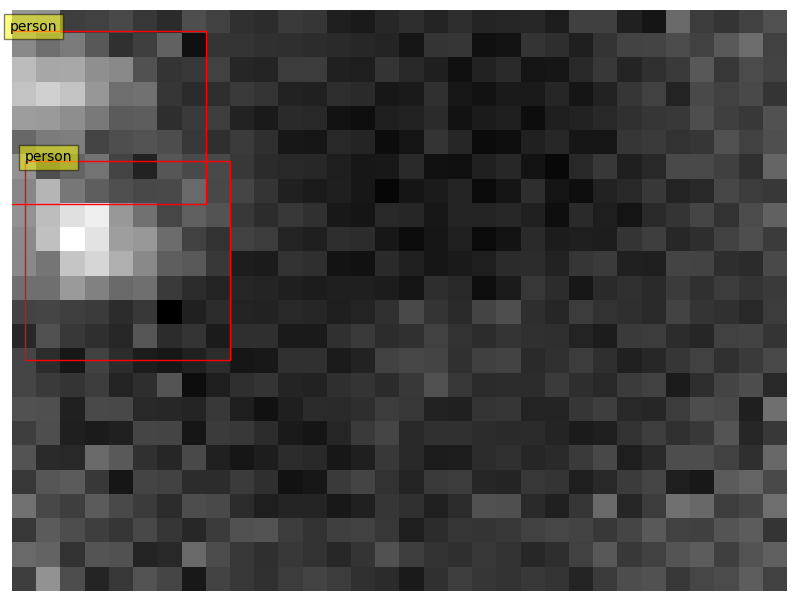

1/1 [==============================] - 0s 26ms/step


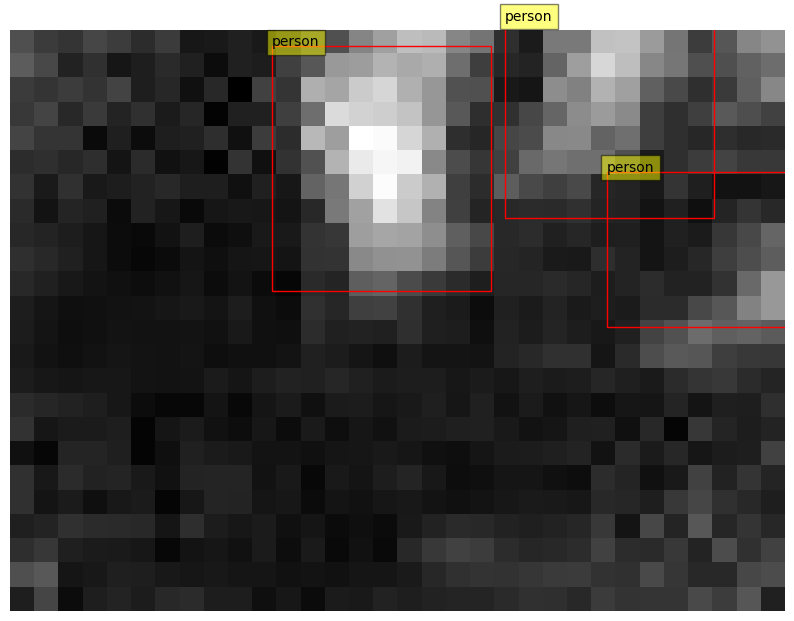

1/1 [==============================] - 0s 26ms/step


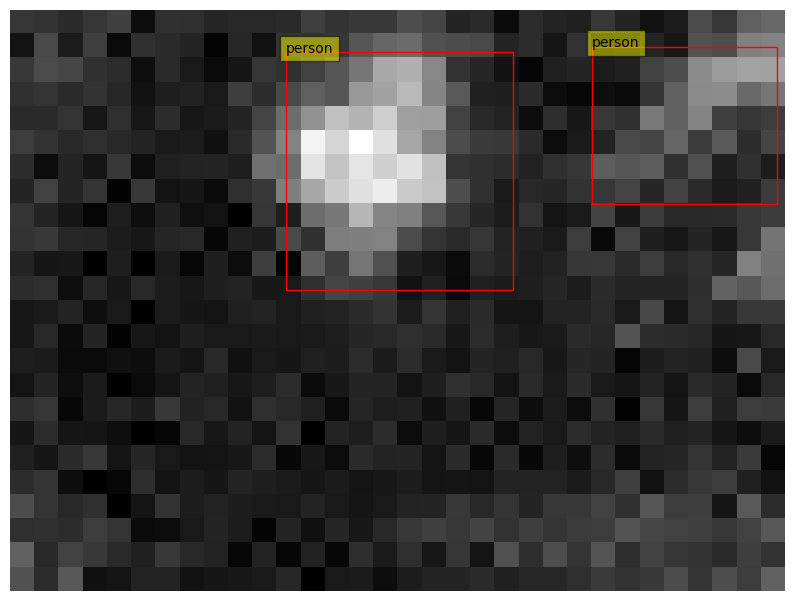

1/1 [==============================] - 0s 26ms/step


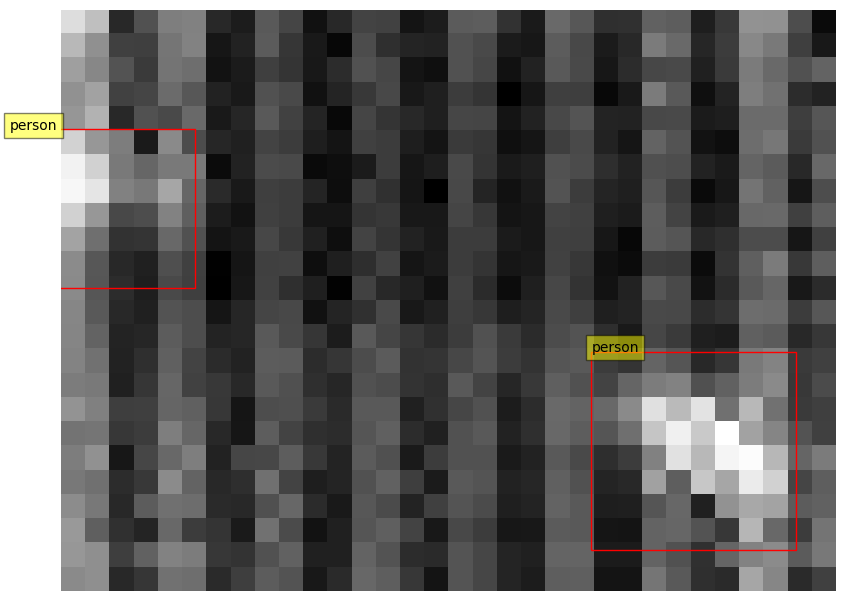

1/1 [==============================] - 0s 24ms/step


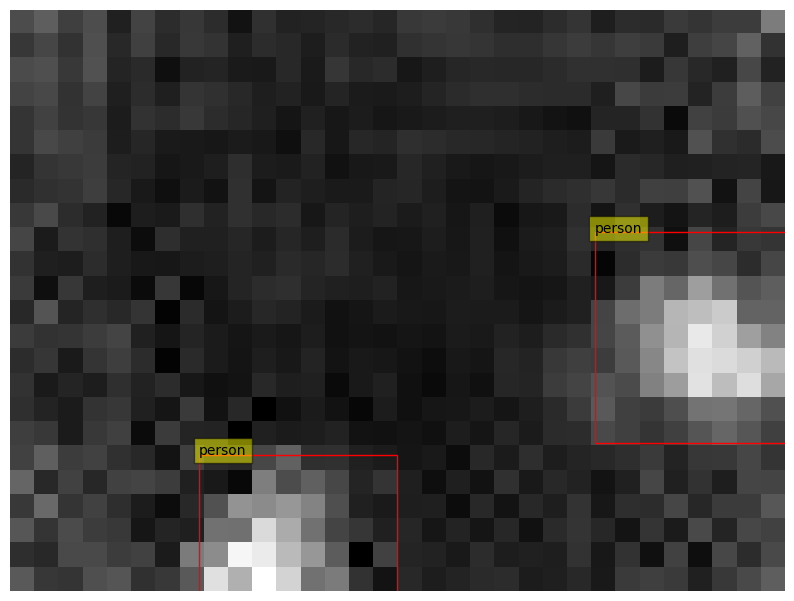

1/1 [==============================] - 0s 26ms/step


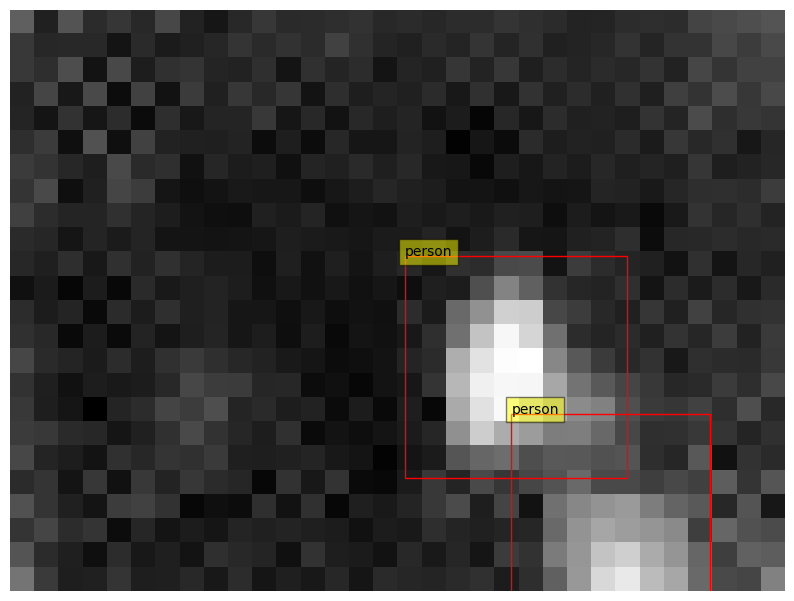

1/1 [==============================] - 0s 25ms/step


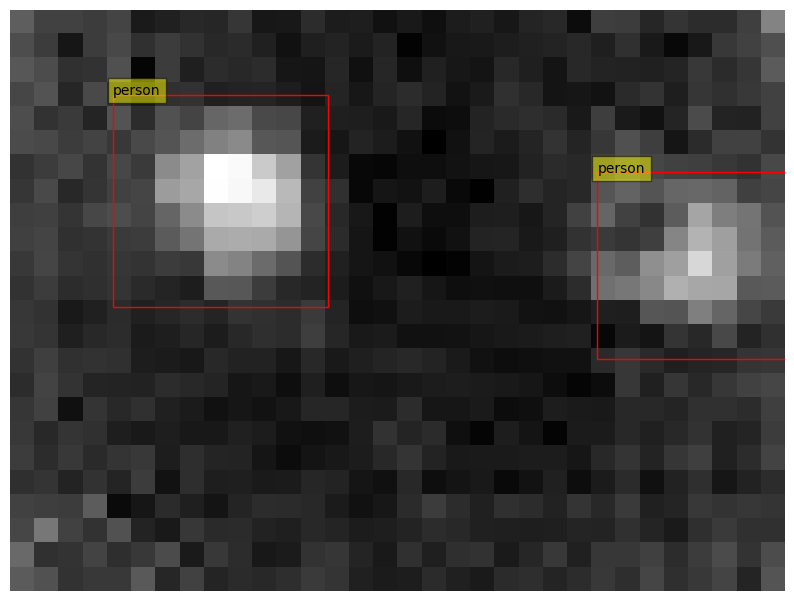

1/1 [==============================] - 0s 25ms/step


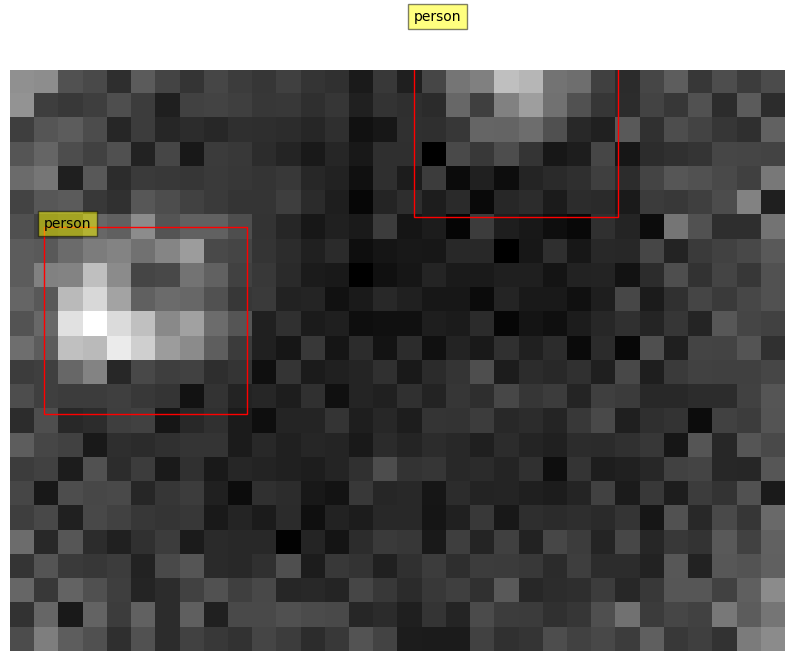

1/1 [==============================] - 0s 25ms/step


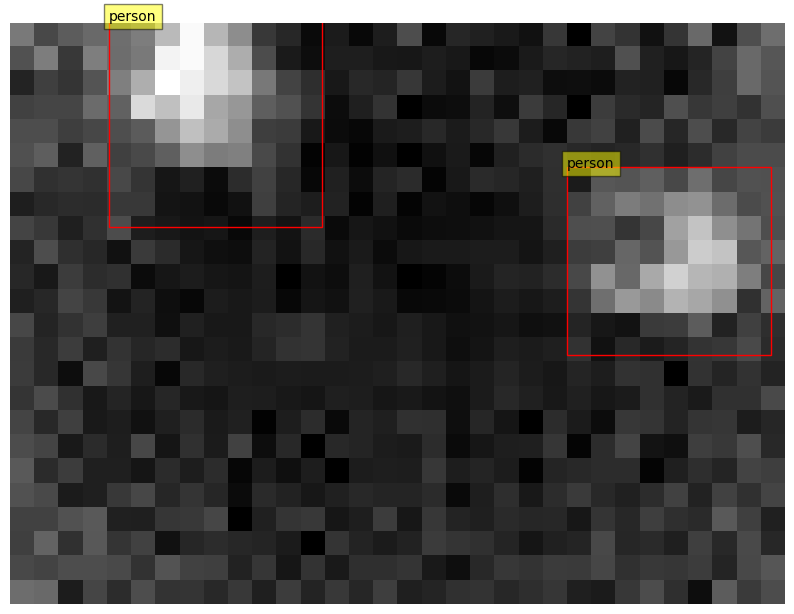

1/1 [==============================] - 0s 25ms/step


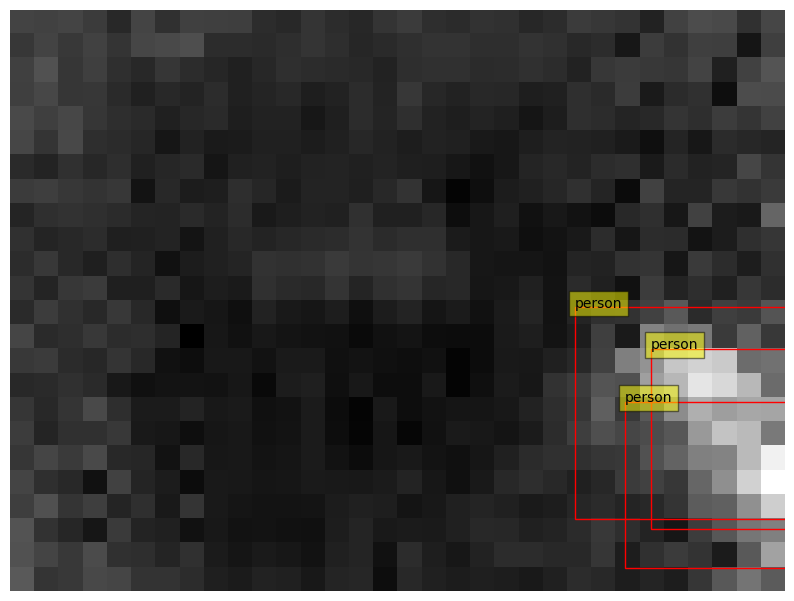

1/1 [==============================] - 0s 26ms/step


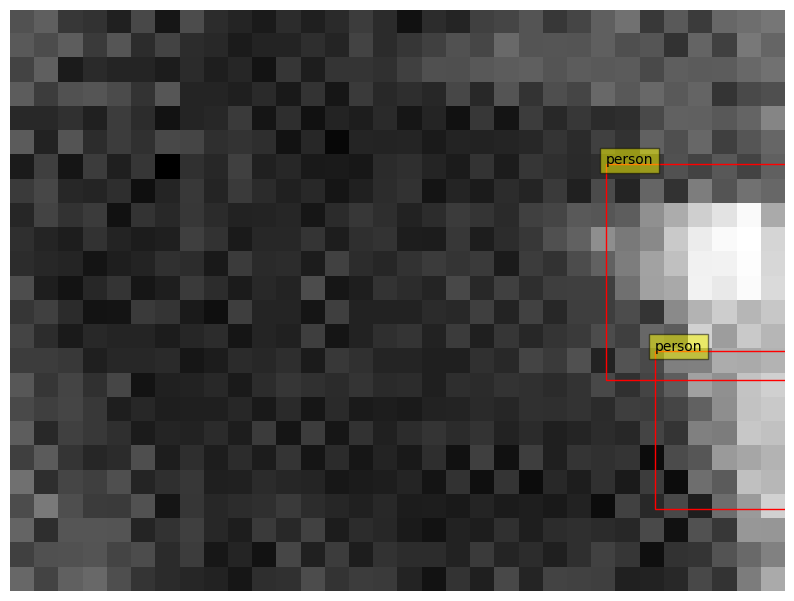

1/1 [==============================] - 0s 28ms/step


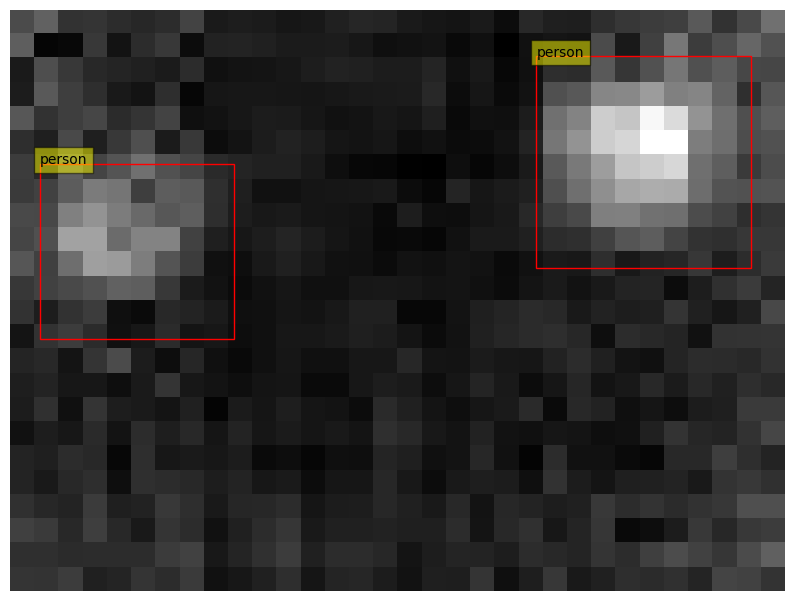

1/1 [==============================] - 0s 27ms/step


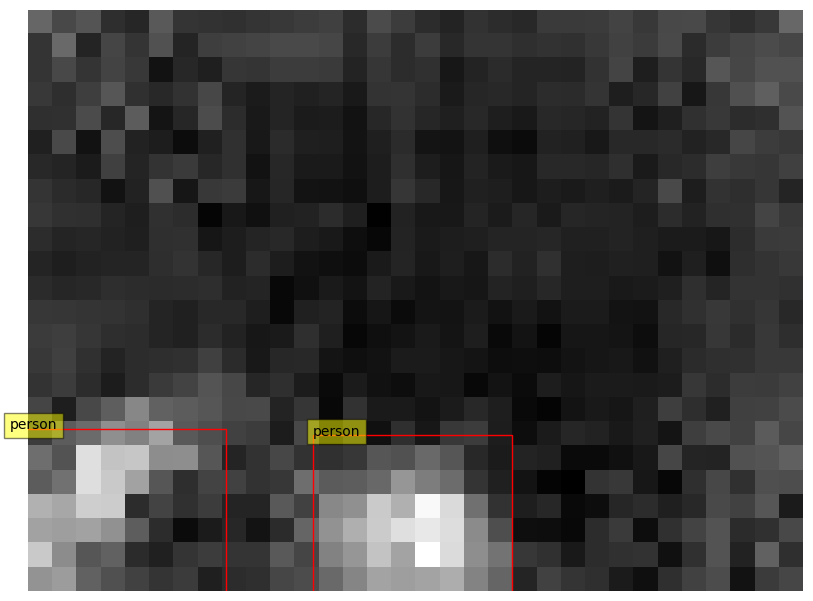

1/1 [==============================] - 0s 27ms/step


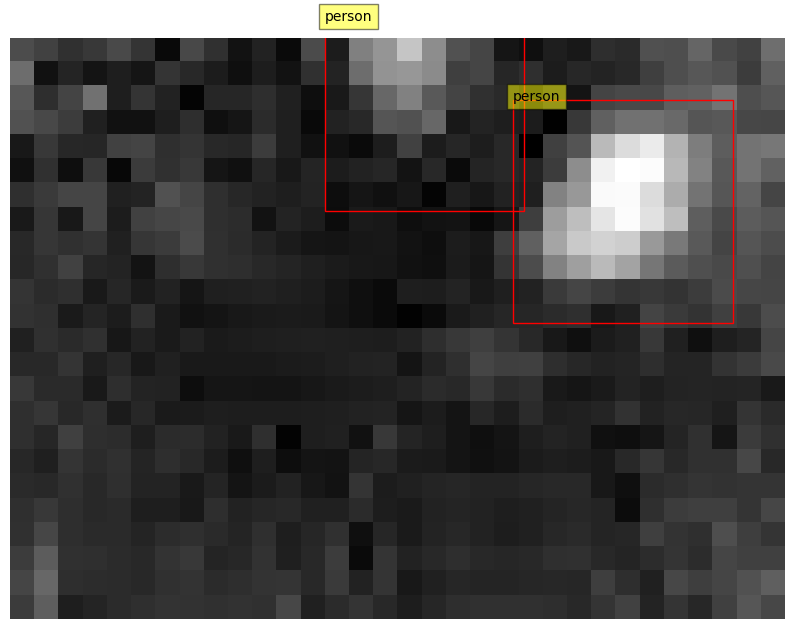

1/1 [==============================] - 0s 26ms/step


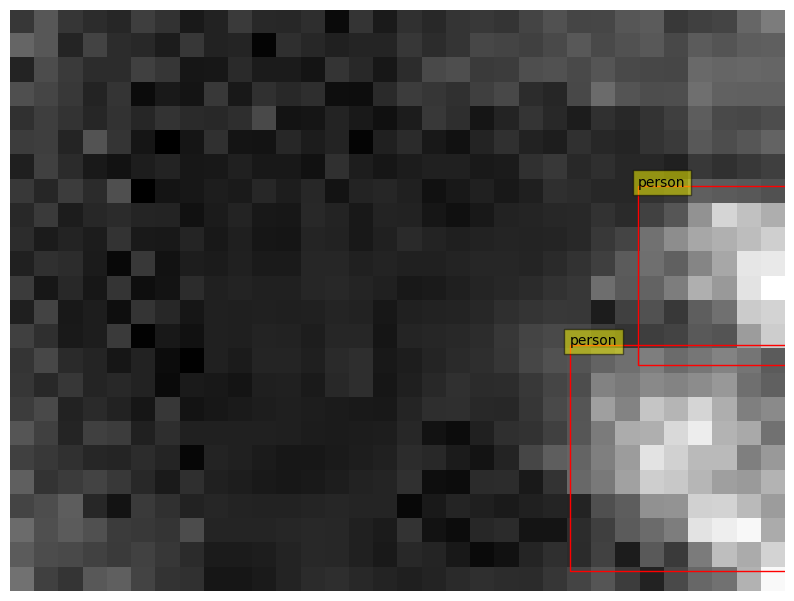

1/1 [==============================] - 0s 25ms/step


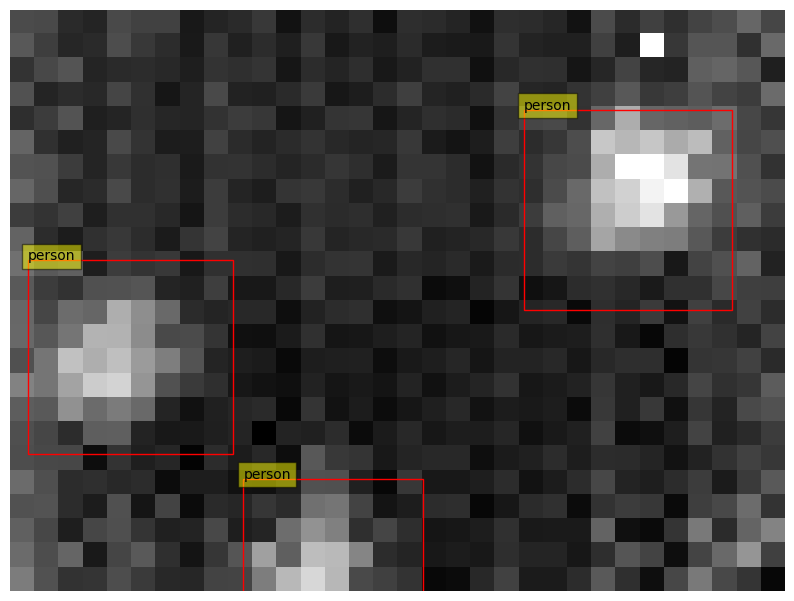

1/1 [==============================] - 0s 26ms/step


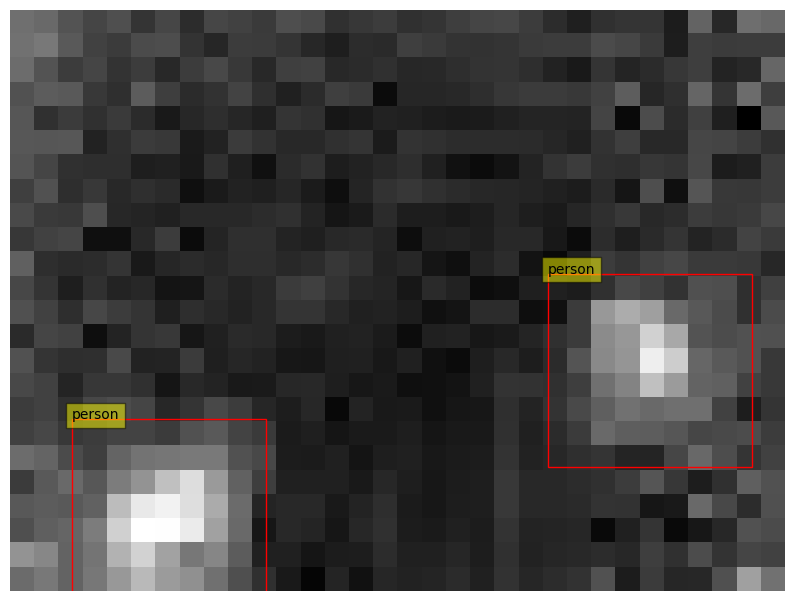

1/1 [==============================] - 0s 26ms/step


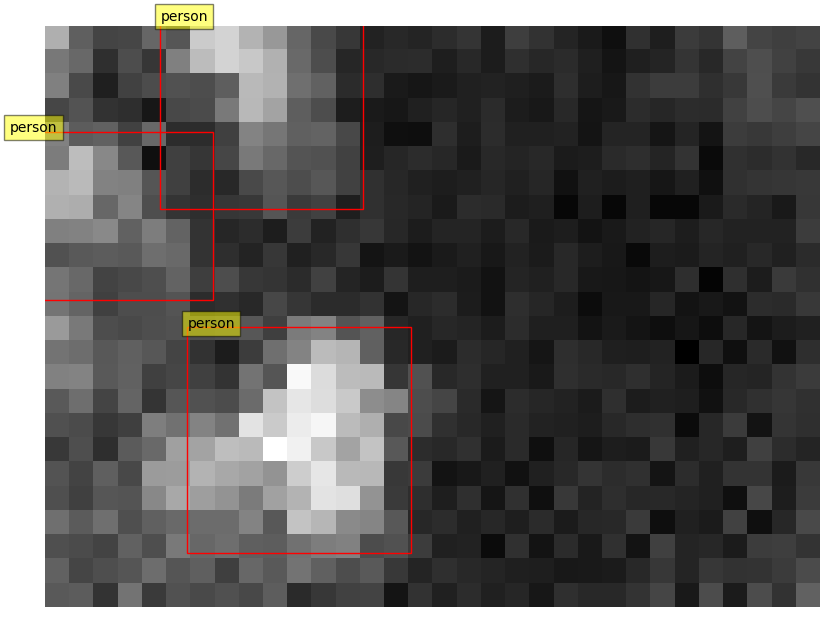

1/1 [==============================] - 0s 27ms/step


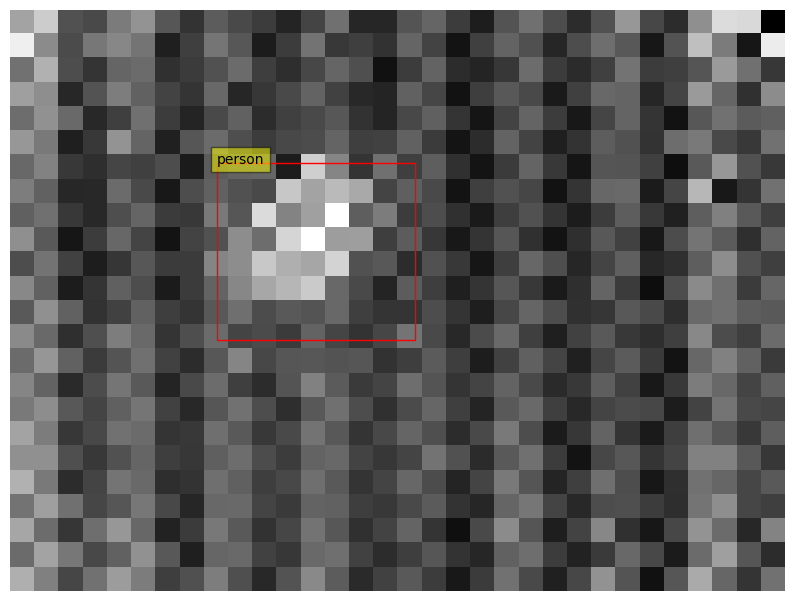

1/1 [==============================] - 0s 25ms/step


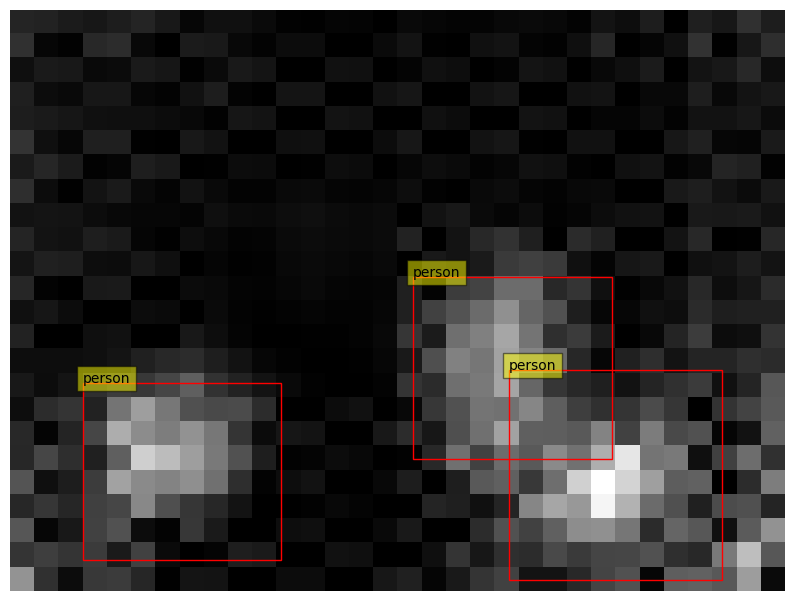

1/1 [==============================] - 0s 26ms/step


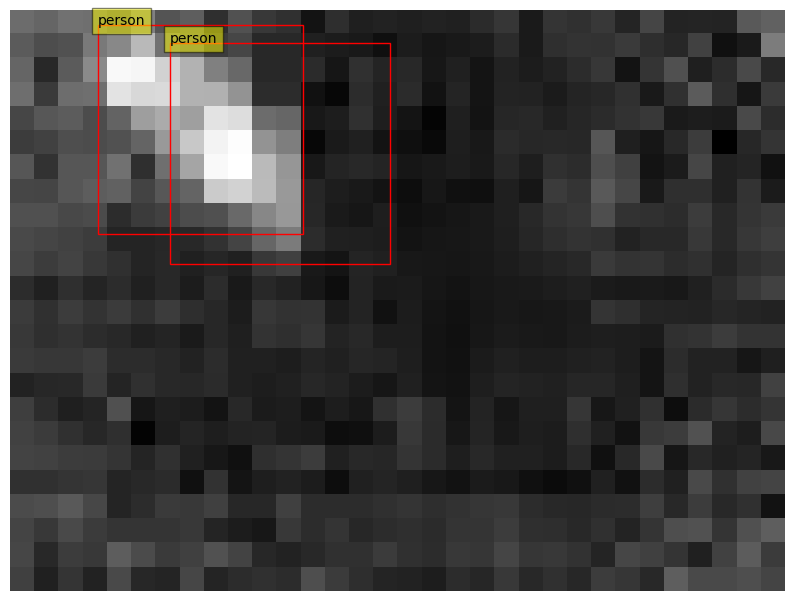

1/1 [==============================] - 0s 26ms/step


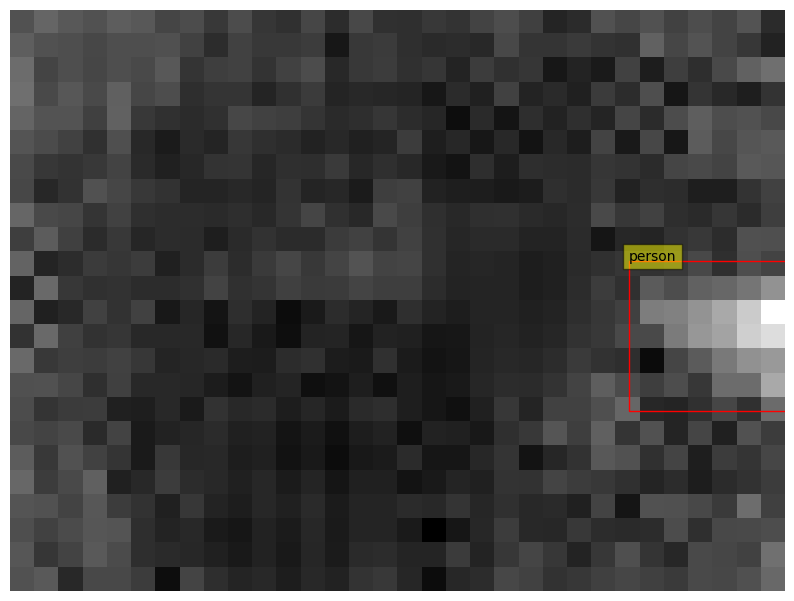

1/1 [==============================] - 0s 26ms/step


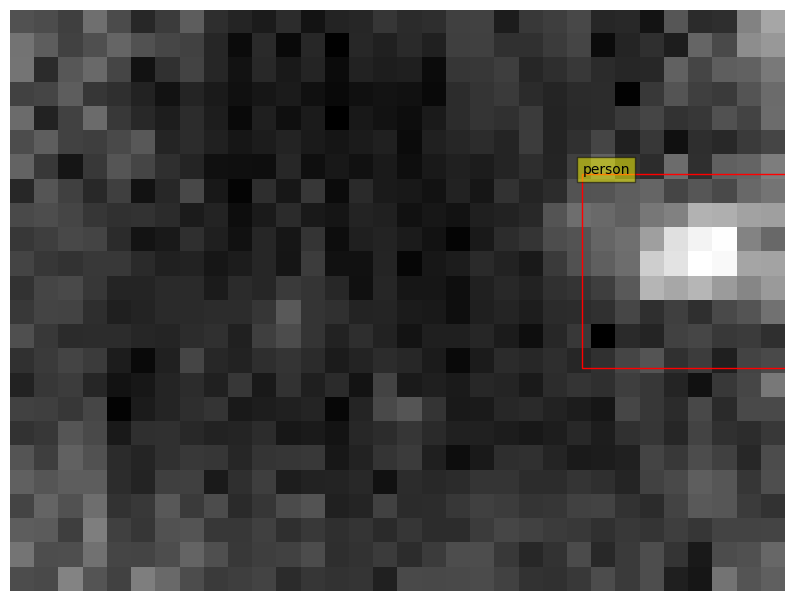

1/1 [==============================] - 0s 25ms/step


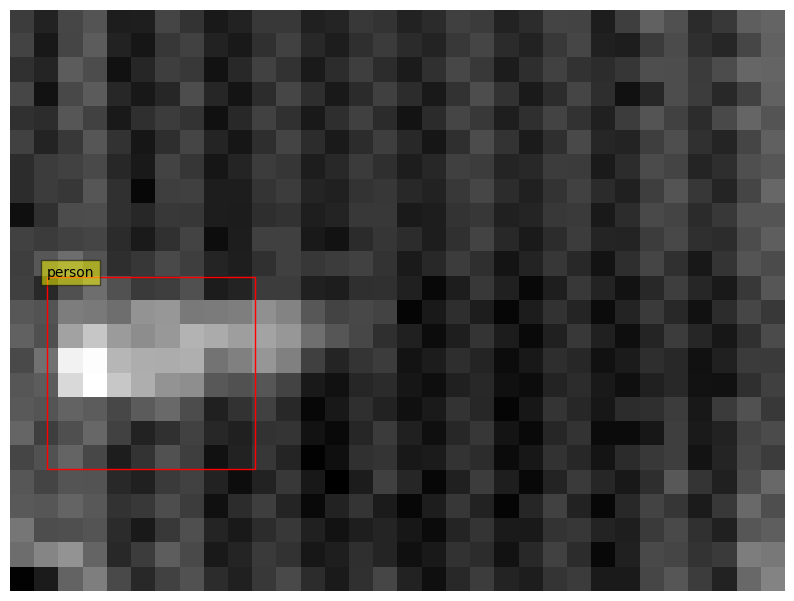

1/1 [==============================] - 0s 29ms/step


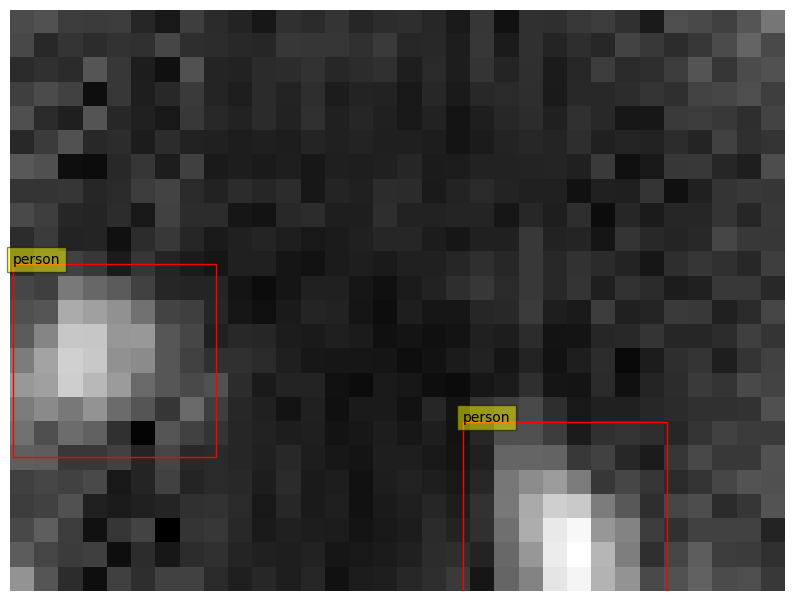

1/1 [==============================] - 0s 26ms/step


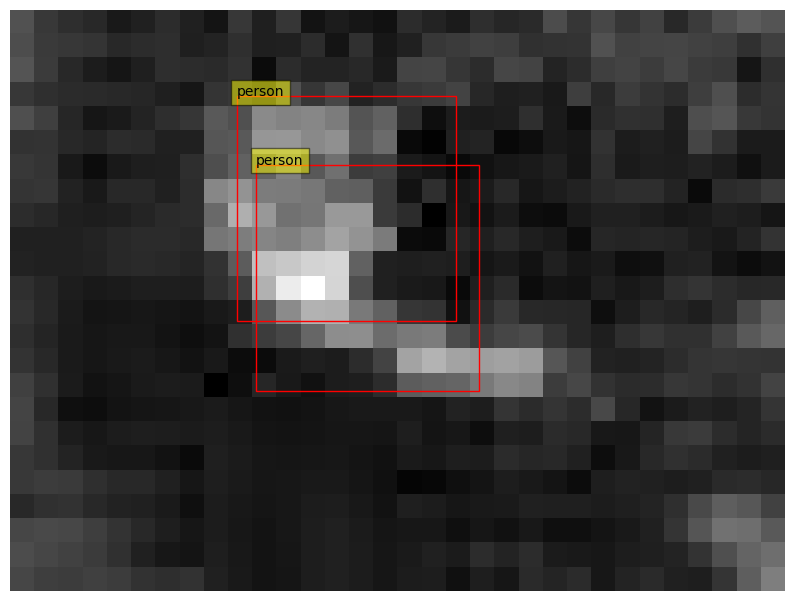

1/1 [==============================] - 0s 26ms/step


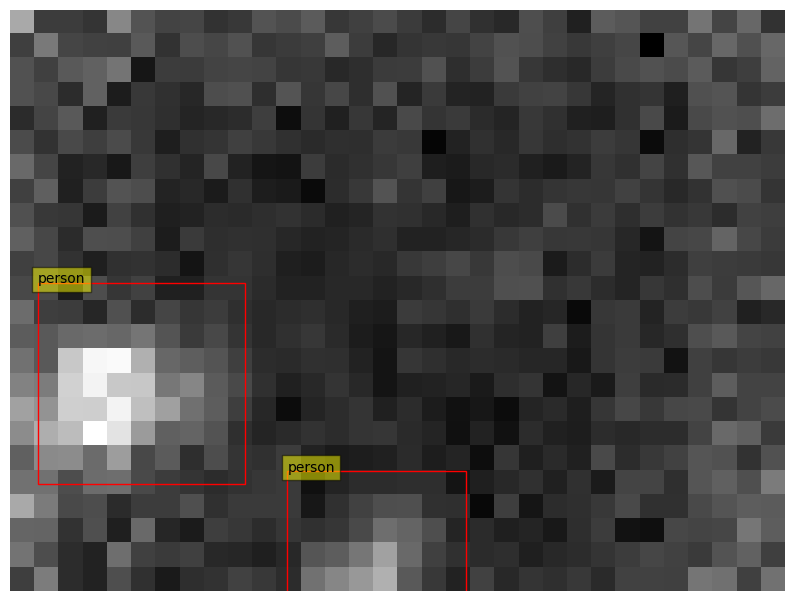

1/1 [==============================] - 0s 26ms/step


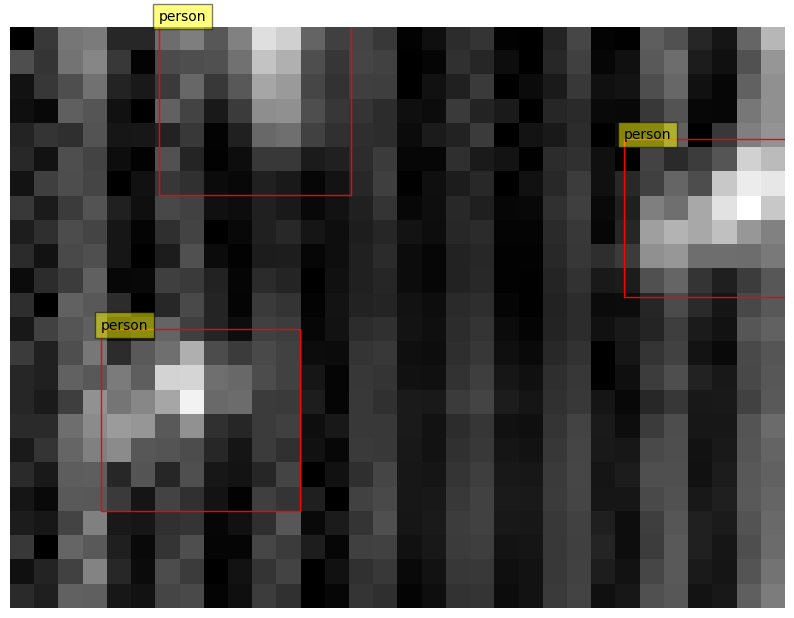

1/1 [==============================] - 0s 29ms/step


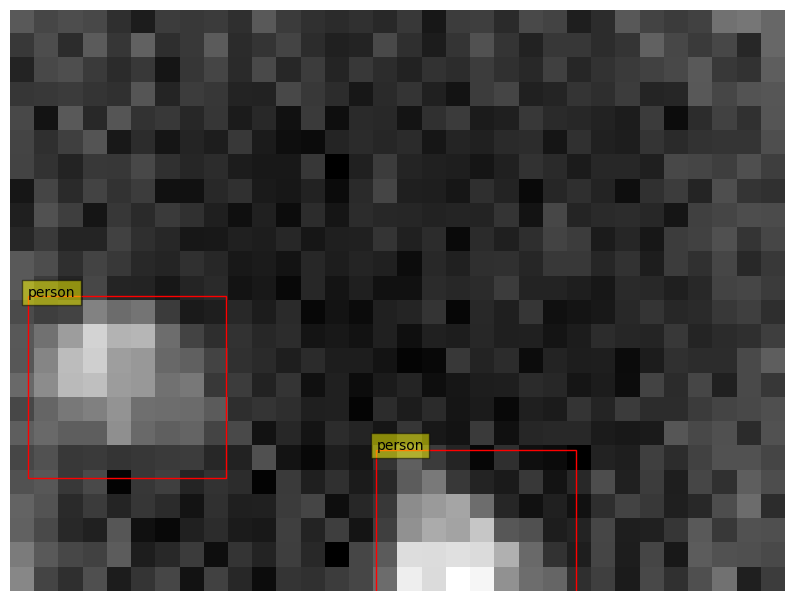

1/1 [==============================] - 0s 26ms/step


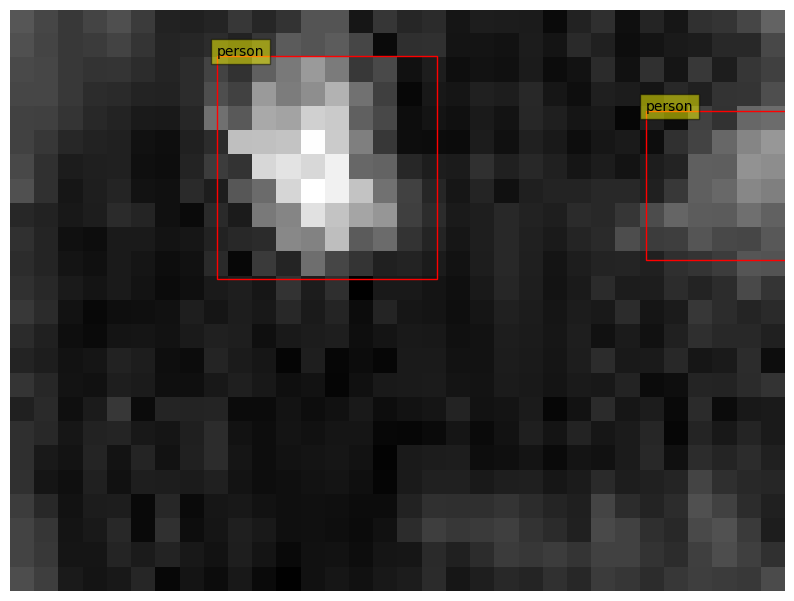

In [58]:
# Epoch 51: LearningRateScheduler setting learning rate to 3.125e-06.
# Epoch 51/100
# 249/473 [==============>...............] - ETA: 6s - loss: 6.8215 - accuracy: 0.7611 - F1Score: 0.6611 - Precision: 0.7209 - Recall: 0.6104


# Epoch 17: LearningRateScheduler setting learning rate to 0.00025.
# Epoch 17/100
# 131/473 [=======>......................] - ETA: 10s - loss: 7.7444 - accuracy: 0.7838 - F1Score: 0.6975 - Precision: 0.7270 - Recall: 0.6702

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf

def iou(box1, box2): 
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2

    x_overlap = max(0, min(x2, x4) - max(x1, x3))
    y_overlap = max(0, min(y2, y4) - max(y1, y3))

    intersection = x_overlap * y_overlap
    area1 = (x2 - x1) * (y2 - y1)
    area2 = (x4 - x3) * (y4 - y3)
    union = area1 + area2 - intersection

    return intersection / union

def decode_predictions(predictions, anchors, box_variance=[0.1, 0.1, 0.2, 0.2], iou_threshold=0.5, score_threshold=0.5, top_n=20):
    decoded_boxes = []
    scores = []
    for i, prediction in enumerate(predictions):
        score = prediction[-1]
        if score > score_threshold:
            scores.append((score, i))

    # 점수에 따라 내림차순 정렬
    scores.sort(reverse=True)

    # 상위 N개 선택
    scores = scores[:top_n]

    # NMS 적용
    while scores:
        score, i = scores.pop(0)
        prediction = predictions[i]
        dx, dy, dw, dh = prediction[:4]
        anchor = anchors[i]
        anchor_x, anchor_y, anchor_w, anchor_h = anchor
        cx = dx * box_variance[0] * anchor_w + anchor_x
        cy = dy * box_variance[1] * anchor_h + anchor_y
        width = np.exp(dw * box_variance[2]) * anchor_w
        height = np.exp(dh * box_variance[3]) * anchor_h
        x_min = cx - width / 2
        y_min = cy - height / 2
        decoded_box = [x_min, y_min, x_min + width, y_min + height, score]
        keep = True
        for other_box in decoded_boxes:
            if iou(decoded_box[:4], other_box[:4]) >= iou_threshold:
                keep = False
                break
        if keep:
            decoded_boxes.append(decoded_box)

    return decoded_boxes

def draw_bounding_boxes(image, boxes, class_names):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')  # 이미지가 grayscale인 경우 cmap='gray'를 추가합니다.
    ax = plt.gca()
    for box in boxes:
        x_min, y_min, x_max, y_max, score = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # 박스 위에 클래스 이름과 확률 표시
        class_name = class_names[0]  # 예시로 'person' 클래스를 사용합니다.
        # text = f'{class_name}: {score / 4:.2f}'
        text = f'{class_name}'
        ax.text(x_min, y_min, text, fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

# AnchorBox 클래스와 get_anchors 함수가 필요합니다.
anchor_box = AnchorBox()
anchors = anchor_box.get_anchors(24, 32)  # 앵커 박스 생성 예시

class_names = ['person']  # 클래스 이름 리스트

for img, _, in val_dataset.take(30):    
    predictions = model.predict(tf.expand_dims(img[0], axis=0))[0]  # 첫 번째 이미지에 대한 예측 결과
    decoded_boxes = decode_predictions(predictions, anchors)  # 예측된 바운딩 박스 디코딩
    draw_bounding_boxes(img[0].numpy(), decoded_boxes, class_names)  # 디코딩된 바운딩 박스를 이미지에 그리기
